### TokaMaker Example: Equilibrium reconstruction in DIII-D Using Real Data {#doc_tMaker_DIIID_ex4}
==========
In this example we show how to perform an equilibrium reconstruction in DIII-D using real data from a gEQDSK file, a k-file and a MHDIn.dat file.

**Warning:** The reconstruction functionality in TokaMaker is still a work in progress, as the PSI-Tri capabilities are activated and tested. Please use with care.

In [1]:
import os
import sys
import json
import random
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import gs_Domain
from OpenFUSIONToolkit.TokaMaker.reconstruction import reconstruction
from OpenFUSIONToolkit.TokaMaker.util import read_eqdsk, read_mhdin, read_kfile

## Initialize TokaMaker object
We now create a \ref OpenFUSIONToolkit.OFT_env "OFT_env" instance for execution using two threads and a \ref OpenFUSIONToolkit.TokaMaker.TokaMaker "TokaMaker" instance to use for equilibrium calculations. Note at present only a single `TokaMaker` instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [3]:
myOFT = OFT_env(nthreads=2)
mygs = TokaMaker(myOFT)

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main_john
Revision id:          c503095
Parallelization Info:
  # of MPI tasks      =    1
  # of NUMA nodes     =    1
  # of OpenMP threads =    2
Fortran input file    = /var/folders/52/n5qxh27n4w19qxzqygz2btbw0000gn/T/oft_23417/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



## Load Info from gEQDSK File and MHDIn.Dat


In [4]:
shot_tag = '183593.04500'
shot_tag = '174864.02400'
# shot_tag = '194414.05250'
eqdsk = read_eqdsk('DIIID_files/g'+shot_tag)

e_coil_names = ['ECOILA','ECOILB','E567UP','E567DN','E89DN','E89UP']
f_coil_names = ['F1A', 'F2A', 'F3A', 'F4A', 'F5A', 'F6A', 'F7A', 'F8A', 'F9A', 'F1B', 'F2B', 'F3B', 'F4B', 'F5B', 'F6B', 'F7B', 'F8B', 'F9B']

machine_dict = read_mhdin('DIIID_files/mhdin.dat', e_coil_names, f_coil_names)

## Build Mesh in TokaMaker
Now we build and setup a mesh using DIII-D geometry from a given JSON file and MHDIn.dat. Then, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup()" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0. These values come from the gEQDSK file.

In [5]:
plasma_dx = 0.04
coil_dx = 0.03
vv_dx = 0.04
vac_dx = 0.10

with open('DIIID_files/DIIID_geom.json','r') as fid:
    DIIID_geom = json.load(fid)

# Create a G-S domain
gs_mesh = gs_Domain()
# Define region information for mesh
gs_mesh.define_region('air',vac_dx,'boundary')                     # Define the bounding region
gs_mesh.define_region('plasma',plasma_dx,'plasma')                 # Define the plasma region and resolution
gs_mesh.define_region('vacuum',vv_dx,'vacuum',allow_xpoints=True)  # Define the vacuum inside the VV
# Define regions for VV
for i, vv_segment in enumerate(DIIID_geom["vv"]):
    gs_mesh.define_region('vv{0}'.format(i),vv_dx,'conductor',eta=vv_segment[1])

# Define geometry
gs_mesh.add_polygon(DIIID_geom['limiter'],'plasma',parent_name='vacuum')  # Define the shape of the limiter
gs_mesh.add_enclosed([1.75,1.25],'vacuum')
# Define regions for VV
for i, vv_segment in enumerate(DIIID_geom["vv"]):
    gs_mesh.add_polygon(vv_segment[0],'vv{0}'.format(i),parent_name='air')


### Load E and F Coils from MHDIn.Dat

In [6]:
# Define F coils
for key, coil in DIIID_geom["coils"].items():
    if key.startswith('ECOIL'):
        continue
    gs_mesh.define_region(key,coil_dx,'coil',nTurns=machine_dict['FCOIL'][key][4])
    gs_mesh.add_polygon(coil["pts"],key,parent_name='air')

# Define E Coils
for coil_set_name, coil_set in machine_dict['ECOIL'].items():
    i = 0
    for coil in coil_set:
        coil_name = "{}_{}".format(coil_set_name, i)
        i = i + 1
        r, z, w, h = coil
        gs_mesh.define_region(coil_name,coil_dx,'coil',coil_set=coil_set_name,nTurns=1) # Check nTurns
        gs_mesh.add_rectangle(r, z, w, h, coil_name, parent_name='air')


### Plot Topology

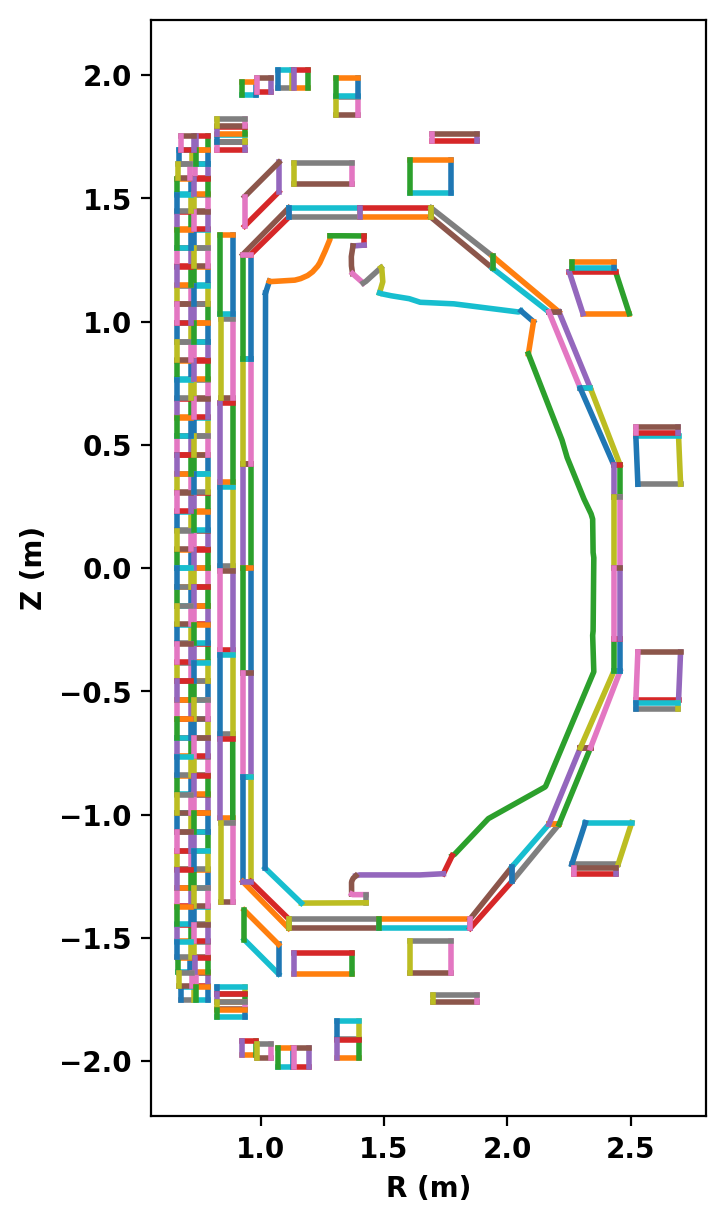

In [7]:
fig, ax = plt.subplots(1,1,figsize=(4,6),constrained_layout=True)
gs_mesh.plot_topology(fig,ax)

plt.show()

### Setup Mesh

In [8]:
mesh_pts, mesh_lc, mesh_reg = gs_mesh.build_mesh()
coil_dict = gs_mesh.get_coils()
cond_dict = gs_mesh.get_conductors()

mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order = 2, F0 = eqdsk['rcentr']*eqdsk['bcentr'])

Assembling regions:
  # of unique points    = 1836
  # of unique segments  = 657
Generating mesh:
  # of points  = 12951
  # of cells   = 25740
  # of regions = 167

**** Loading OFT surface mesh

**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  1.574E+01
    # of points  =   12951
    # of edges   =   38690
    # of cells   =   25740
    # of boundary points =     160
    # of boundary edges  =     160
    # of boundary cells  =     160
  Resolution statistics:
    hmin =  8.702E-04
    hrms =  4.001E-02
    hmax =  1.520E-01
  Surface grounded at vertex    1813


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    2.8879999999999999E-003


## Update GS Settings

In [9]:
# Update maximum number of solver iterations
mygs.settings.maxits=1000
# mygs.settings.sol_currents = True
mygs.update_settings()

## Define hard limits on coil currents
Hard limits on coil currents can be set using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_bounds "set_coil_bounds()". In this case we just the simple and approximate bi-directional limit of 5 MA in each coil.

Bounds are specified using a dictionary of 2 element lists, containing the minimum and maximum bound, where the dictionary key corresponds to the coil names, which are available in \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.coil_sets "mygs.coil_sets"

In [10]:
coil_bounds = {key: [-5.E6, 5.E6] for key in mygs.coil_sets}
mygs.set_coil_bounds(coil_bounds)

## Define vertical stability coils

In [11]:
vsc_signs = {key: 0 for key in mygs.coil_sets}
vsc_signs['F9A'] = 1.0
vsc_signs['F9B'] = -1.0
mygs.set_coil_vsc(vsc_signs)

## Perform Reconstruction

### Create Reconstruction Object

In [12]:
myrecon = reconstruction(mygs)

### Define Helper Functions to Read Sensor Locations
For this example we load data representing flux loops and Mirnov sensor locations and orientations in DIII-D from several text files. The signals in these sensors will be used to constrain the reconstruction along with coil currents and global plasma quantities (eg. $I_p$). First we define two helper functions to read Flux Loop and Mirnov sensor configurations.

In [13]:
def read_points_flux(file_path,  sensor_names = None):
    points = OrderedDict()
    with open(file_path, 'r') as file:
        for line in file:
            if sensor_names is not None:
                name, r, z = line.strip().split()  # Split and ignore the first field (name)
                if name in sensor_names:
                    points[name] = [float(r),float(z)]
            else:
                name, r, z = line.strip().split()  # Split and ignore the first field (name)
                points[name] = [float(r),float(z)]
    return points
    
def read_points_mag(file_path, sensor_names = None):
    points = OrderedDict()
    with open(file_path, 'r') as file:
        for line in file:
            if sensor_names is not None: 
                name, r, z, pol, orient, _, _, _ = line.strip().split()  # Split and ignore the first field (name)
                if name in sensor_names:
                    points[name] = [float(r), float(z), float(orient)]
            else: 
                name, r, z, pol, orient, _, _, _ = line.strip().split()  # Split and ignore the first field (name)
                points[name] = [float(r), float(z), float(orient)]  # Convert r and z to floats and append
    return points

### Load Sensor Locations From Files

In [14]:
magSensors322 = read_points_mag('DIIID_files/3222magsensorloc.txt')
fluxLoops_onf = read_points_flux('DIIID_files/fcoil_fluxloops.txt')
fluxLoops_vv = read_points_flux('DIIID_files/vv_fluxloops.txt')

### Plot probe locations

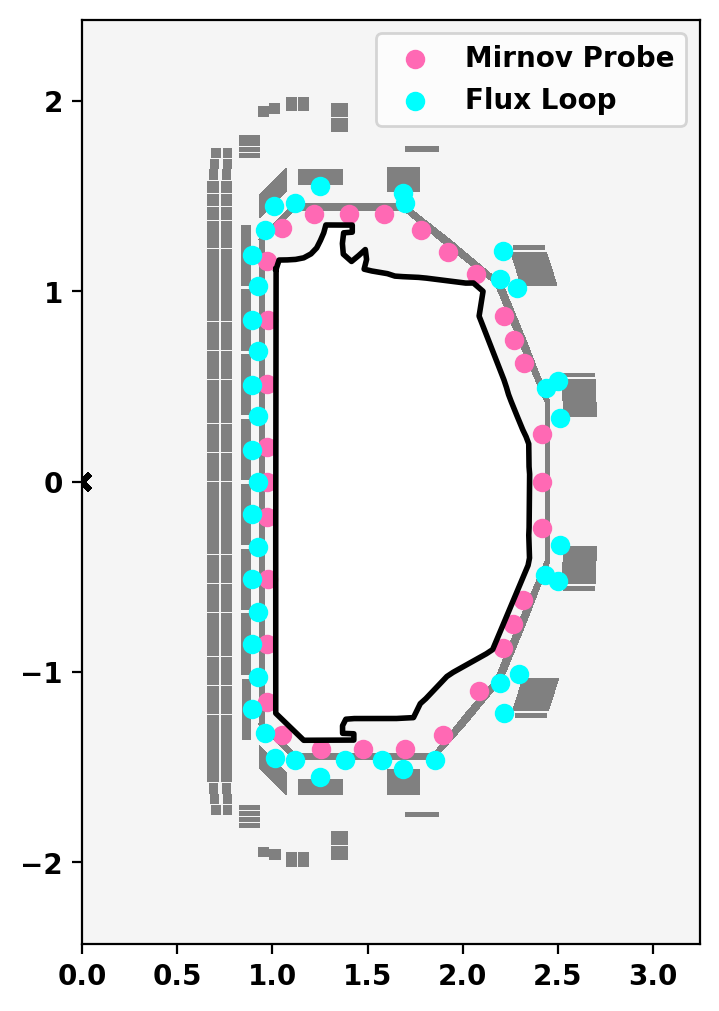

In [15]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color='k')
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_constraints(fig, ax)

def plot_sensors(sensors, label, color):
    r_coords = [s[0] for _,s in sensors.items()]
    z_coords = [s[1] for _,s in sensors.items()]
    ax.scatter(x=r_coords, y=z_coords, label=label, color=color)

plot_sensors(magSensors322, label="Mirnov Probe", color='hotpink')
plot_sensors({**fluxLoops_vv, **fluxLoops_onf}, label="Flux Loop", color='cyan')

ax.legend()
plt.show()

### Load Shot Data from DIII-D
Here we load data from a DIII-D k file representing a shot at a given point in time.

In [16]:
probes_dict, loops_dict, e_coil_dict, f_coil_dict = read_kfile('DIIID_files/k'+shot_tag, e_coil_names, f_coil_names, machine_dict)

### Read Data From DIII-D to Mirnov Probes

In [17]:
def convert_Mirnov_coordinates(sensor, angle):
    R, z, _ = sensor
    position = np.array([R, z])

    angle_rads = angle * np.pi / 180
    orientation = np.array([np.cos(angle_rads), 0, np.sin(angle_rads)])
    return position, orientation

B_vals = [probes_dict[key][0] for key in magSensors322 if key in probes_dict]
B_mean = np.mean(np.positive(B_vals))
mirnov_names = []

for key, mag in magSensors322.items():
    mirnov_names.append(key)
    position, orientation = convert_Mirnov_coordinates(mag, machine_dict['AMP2'][key])
    B_meas, _ = probes_dict[key]
    myrecon.add_Mirnov(position, orientation, B_meas, err=0.1*max(B_mean, abs(B_meas)))


### Read Data From Equilibrium to Flux Loops

In [18]:
flux_locs = []
flux_vals = []

psi_vals_1 = [loops_dict[key][0] for key in fluxLoops_onf if key in loops_dict]
psi_mean_1 = np.mean(np.positive(psi_vals_1))
psi_vals_2 = [loops_dict[key][0] for key in fluxLoops_vv if key in loops_dict]
psi_mean_2 = np.mean(np.positive(psi_vals_2))

flux_names = []

for key, fl in fluxLoops_onf.items():
    if key not in loops_dict:
        continue
    flux_names.append(key)
    B_tmp, _ = loops_dict[key]
    flux_locs.append(fl)
    flux_vals.append(B_tmp)
    psi_val = B_tmp*2.0*np.pi
    myrecon.add_flux_loop(fl, psi_val, err=0.1*(max(psi_mean_1, abs(psi_val))))

for key, fl in fluxLoops_vv.items():
    if key not in loops_dict:
        continue
    flux_names.append(key)
    B_tmp, _ = loops_dict[key]
    flux_locs.append(fl)
    flux_vals.append(B_tmp)
    psi_val = B_tmp*2.0*np.pi
    myrecon.add_flux_loop(fl, psi_val, err=0.1*(max(psi_mean_2, abs(psi_val))))

## Profiles

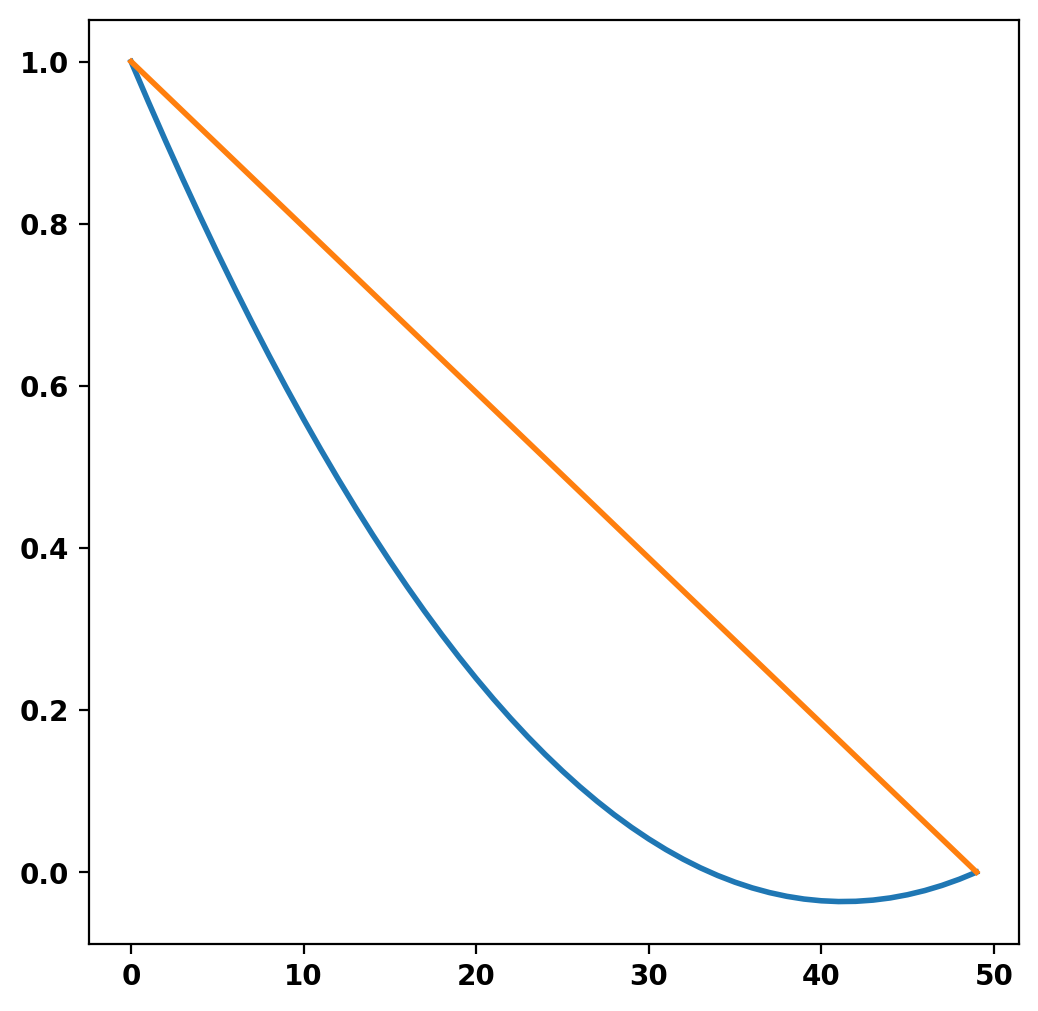

In [19]:
ffprim = eqdsk['ffprim']
pprime = eqdsk['pprime']


psi_eqdsk = np.linspace(0.0,1.0,np.size(ffprim))
psi_sample = np.linspace(0.0,1.0,50)

psi_prof = np.copy(psi_sample)
ffp_prof = np.transpose(np.vstack((psi_prof,np.interp(psi_sample,psi_eqdsk,ffprim)))).copy()
pp_prof = np.transpose(np.vstack((psi_prof,np.interp(psi_sample,psi_eqdsk,pprime)))).copy()

ffp_prof[:,1] -= ffp_prof[-1,1]
pp_prof[:,1] -= pp_prof[-1,1]
plt.plot(ffp_prof[:,1]/ffp_prof[0,1])
plt.plot(pp_prof[:,1]/pp_prof[0,1])

# mygs.set_profiles(pp_prof={'type': 'linterp', 'y': pp_prof[:,1], 'x': psi_sample})
mygs.set_profiles(ffp_prof={'type': 'linterp', 'y': ffp_prof[:,1], 'x': psi_sample},pp_prof={'type': 'linterp', 'y': pp_prof[:,1], 'x': psi_sample})

## Compute starting equilibrium

In [20]:
##### Add plasma current and flux loop constraints
Ip_target=abs(eqdsk['ip'])
P0_target=eqdsk['pres'][0]
mygs.set_targets(Ip=Ip_target, pax=P0_target)

mygs.set_flux(np.array(flux_locs), np.array(flux_vals))
# isoflux_pts = eqdsk['rzout'].copy()
# mygs.set_isoflux(isoflux_pts)

target_currents = {}

for key, value in e_coil_dict.items():
    target_currents[key] = value[0]

for key, value in f_coil_dict.items():
    target_currents[key] = value[0] / machine_dict['FCOIL'][key][4]


# Set coil regularization to weakly track measured coil currents
regularization_terms = []
for key in e_coil_dict:
    regularization_terms.append(mygs.coil_reg_term({key: 1.0},
                                                   target=target_currents[key],
                                                   weight=1.0E1))
for key in f_coil_dict:
    weight = 1.0
    if key.startswith('F5'):
        weight = 1.0E2
    regularization_terms.append(mygs.coil_reg_term({key: 1.0},
                                                   target=target_currents[key],
                                                   weight=1.0E2))

# Set zero target current and small weight on virtual VSC to allow up-down adjustment
regularization_terms.append(mygs.coil_reg_term({'#VSC': 1.0},target=0.0,weight=1.E-2))

# # Set regularization weights
# regularization_terms = []
# for name, target_current in target_currents.items():
#     # Set specific target currents from input equilibrium and different weights depending on the coil set
#     if name.startswith('ECOIL'):
#         regularization_terms.append(mygs.coil_reg_term({key: 1.0},target=target_current,weight=61.0))
#     elif name.startswith('F'):
#         if name.startswith('F5'):
#             regularization_terms.append(mygs.coil_reg_term({key: 1.0},target=target_current,weight=1.E2))
#         else:
#             regularization_terms.append(mygs.coil_reg_term({key: 1.0},target=target_current,weight=1.E0))
# # Set zero target current and small weight on virtual VSC to allow up-down adjustment
# regularization_terms.append(mygs.coil_reg_term({'#VSC': 1.0},target=0.0,weight=1.E2))


# Pass regularization terms to TokaMaker
mygs.set_coil_reg(reg_terms=regularization_terms)

# current_bounds = {}

# for key in e_coil_dict:
#     val = target_currents[key]
#     current_bounds[key] = [val - 5.0E2, val + 5.0E2]
# for key in f_coil_dict:
#     val = target_currents[key]
#     current_bounds[key] = [val - 5.0E2, val + 5.0E2]
# # current_bounds.append([-50.E6, 50.E6])
# mygs.set_coil_bounds(current_bounds)

# Initial equilibrium with very rough guess
R0 = eqdsk['rcentr']
Z0 = 0.0
a = 0.6
kappa = 1.13
delta = .1

err_flag = mygs.init_psi(R0, Z0, a, kappa, delta)

# Compute initial equilibrium
mygs.update_settings()
mygs.solve()

Starting non-linear GS solver
     1  1.4895E+00  1.0062E-05  2.2348E-02  1.7029E+00 -3.5686E-02  2.1277E+02
     2 -2.9519E+00  1.1471E-06  5.2390E-03  1.6993E+00 -3.7055E-02  1.6499E+02
     3 -3.7375E+00  8.1962E-07  3.6161E-03  1.7028E+00 -3.6726E-02  1.5199E+02
     4 -4.2241E+00  7.1131E-07  2.6109E-03  1.7086E+00 -3.5987E-02  1.4637E+02
     5 -4.5483E+00  6.6093E-07  2.0498E-03  1.7150E+00 -3.5090E-02  1.4229E+02
     6 -4.7695E+00  6.3297E-07  1.7397E-03  1.7215E+00 -3.4262E-02  1.3875E+02
     7 -4.9221E+00  6.1567E-07  1.5509E-03  1.7277E+00 -3.3301E-02  1.3546E+02
     8 -5.0281E+00  6.0419E-07  1.4150E-03  1.7335E+00 -3.2316E-02  1.3229E+02
     9 -5.1026E+00  5.9619E-07  1.3030E-03  1.7390E+00 -3.1353E-02  1.2914E+02
    10 -5.1559E+00  5.9038E-07  1.2032E-03  1.7441E+00 -3.0387E-02  1.2599E+02
    11 -5.1949E+00  5.8600E-07  1.2142E-03  1.7489E+00 -2.9419E-02  1.2282E+02
    12 -5.2468E+00  5.8566E-07  1.1883E-03  1.7532E+00 -2.8459E-02  1.2077E+02
    13 -5.3178E+00  5.

## Plot starting equilibrium

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    9.9112E+05
  Current Centroid [m]    =    1.845  0.031
  Magnetic Axis [m]       =    1.839  0.031
  Elongation              =    1.151 (U:  1.156, L:  1.146)
  Triangularity           =    0.149 (U:  0.132, L:  0.167)
  Plasma Volume [m^3]     =   12.633
  q_0, q_95               =   -0.158 -1.994
  Peak Pressure [Pa]      =    3.5374E+04
  Stored Energy [J]       =    1.1188E+05
  <Beta_pol> [%]          =   13.8088
  Diamagnetic flux [Wb]   =   -2.7041E-02
  Toroidal flux [Wb]      =   -2.3374E+00
  l_i                     =    2.6878
51641


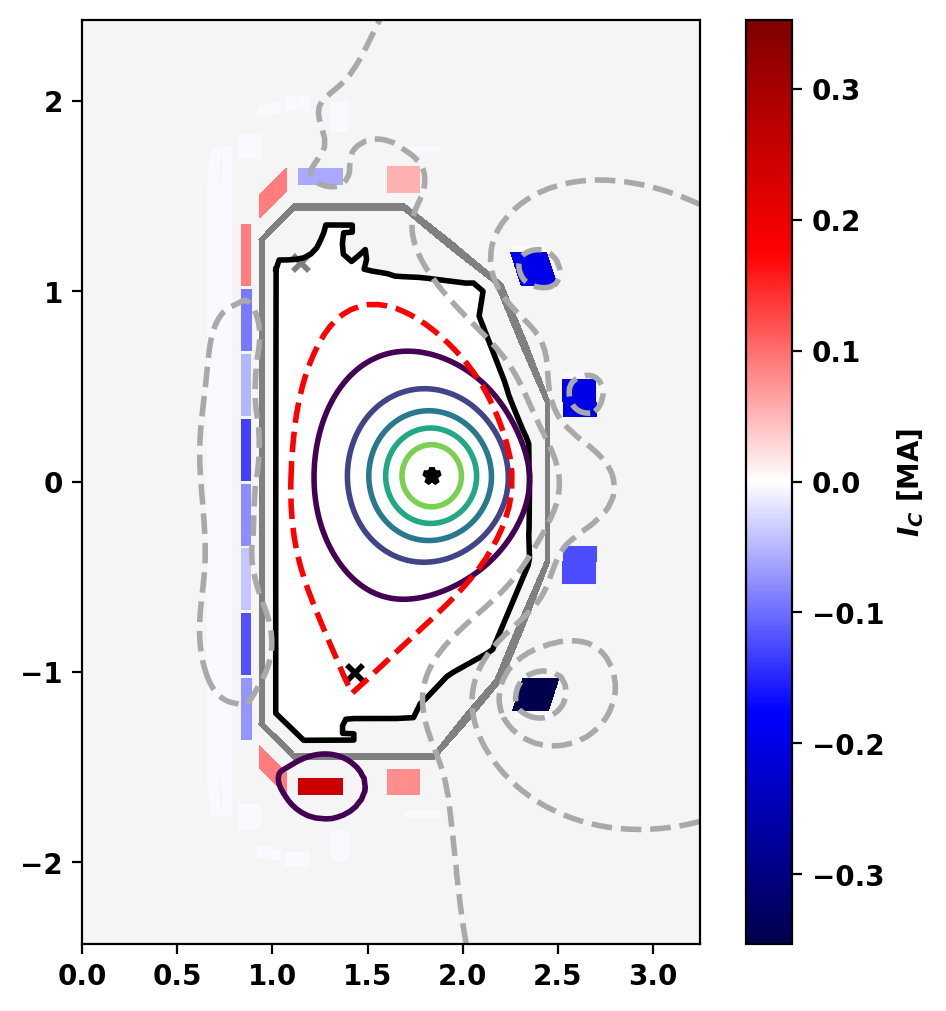

In [21]:
psi_eq = mygs.get_psi()
mygs.print_info()

print(len(psi_eq))

fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True)
mygs.plot_psi(fig,ax,normalized=True,plasma_nlevels=6,vacuum_nlevels=5)
# mygs.plot_psi(fig,ax,psi_eq,plasma_levels=[1.0,],plasma_color='red',vacuum_nlevels=0,plasma_linestyles='dashed')
_ = ax.plot(eqdsk['rzout'][:,0], eqdsk['rzout'][:,1],'r--')
# plot_sensors({**fluxLoops_vv, **fluxLoops_onf}, label="Flux Loop", color='cyan')

plt.show()

In [23]:
print("Coil Currents [kA]:")
coil_currents, _ = mygs.get_coil_currents()
for key, current in coil_currents.items():
    if key not in target_currents:
        continue
    current_adj = current
    # if key.startswith('F'):
    #     current_adj = current/machine_dict['FCOIL'][key][4]
    measured_currt = target_currents[key]
    pct_diff = 100.0 * (current_adj-measured_currt)/measured_currt
    print('  {0:10} {1:11.3F} {2:11.3F} {3:10.2F}%'.format(key+":", current_adj/1.E3, measured_currt/1.E3, pct_diff))

Coil Currents [kA]:
  F1A:            -2.260      -2.263      -0.11%
  F2A:            -0.902      -0.907      -0.59%
  F3A:            -1.607      -1.610      -0.21%
  F4A:             1.565       1.562       0.15%
  F5A:             1.524       1.518       0.39%
  F6A:            -3.696      -3.162      16.89%
  F7A:            -3.589      -3.418       5.00%
  F8A:            -1.031      -1.036      -0.46%
  F9A:             0.965       1.053      -8.33%
  F1B:            -1.375      -1.387      -0.85%
  F2B:            -0.671      -0.690      -2.78%
  F3B:            -2.086      -2.106      -0.93%
  F4B:            -1.281      -1.294      -1.03%
  F5B:             1.547       1.547      -0.01%
  F6B:            -2.242      -1.795      24.86%
  F7B:            -6.416      -6.304       1.76%
  F8B:             4.256       4.260      -0.08%
  F9B:             1.439       1.363       5.55%
  ECOILA:         -3.964      -4.409     -10.10%
  ECOILB:         -4.180      -4.625      -9.62%


## Plot Measured vs. Computed SE Values

### Plot SE Currents

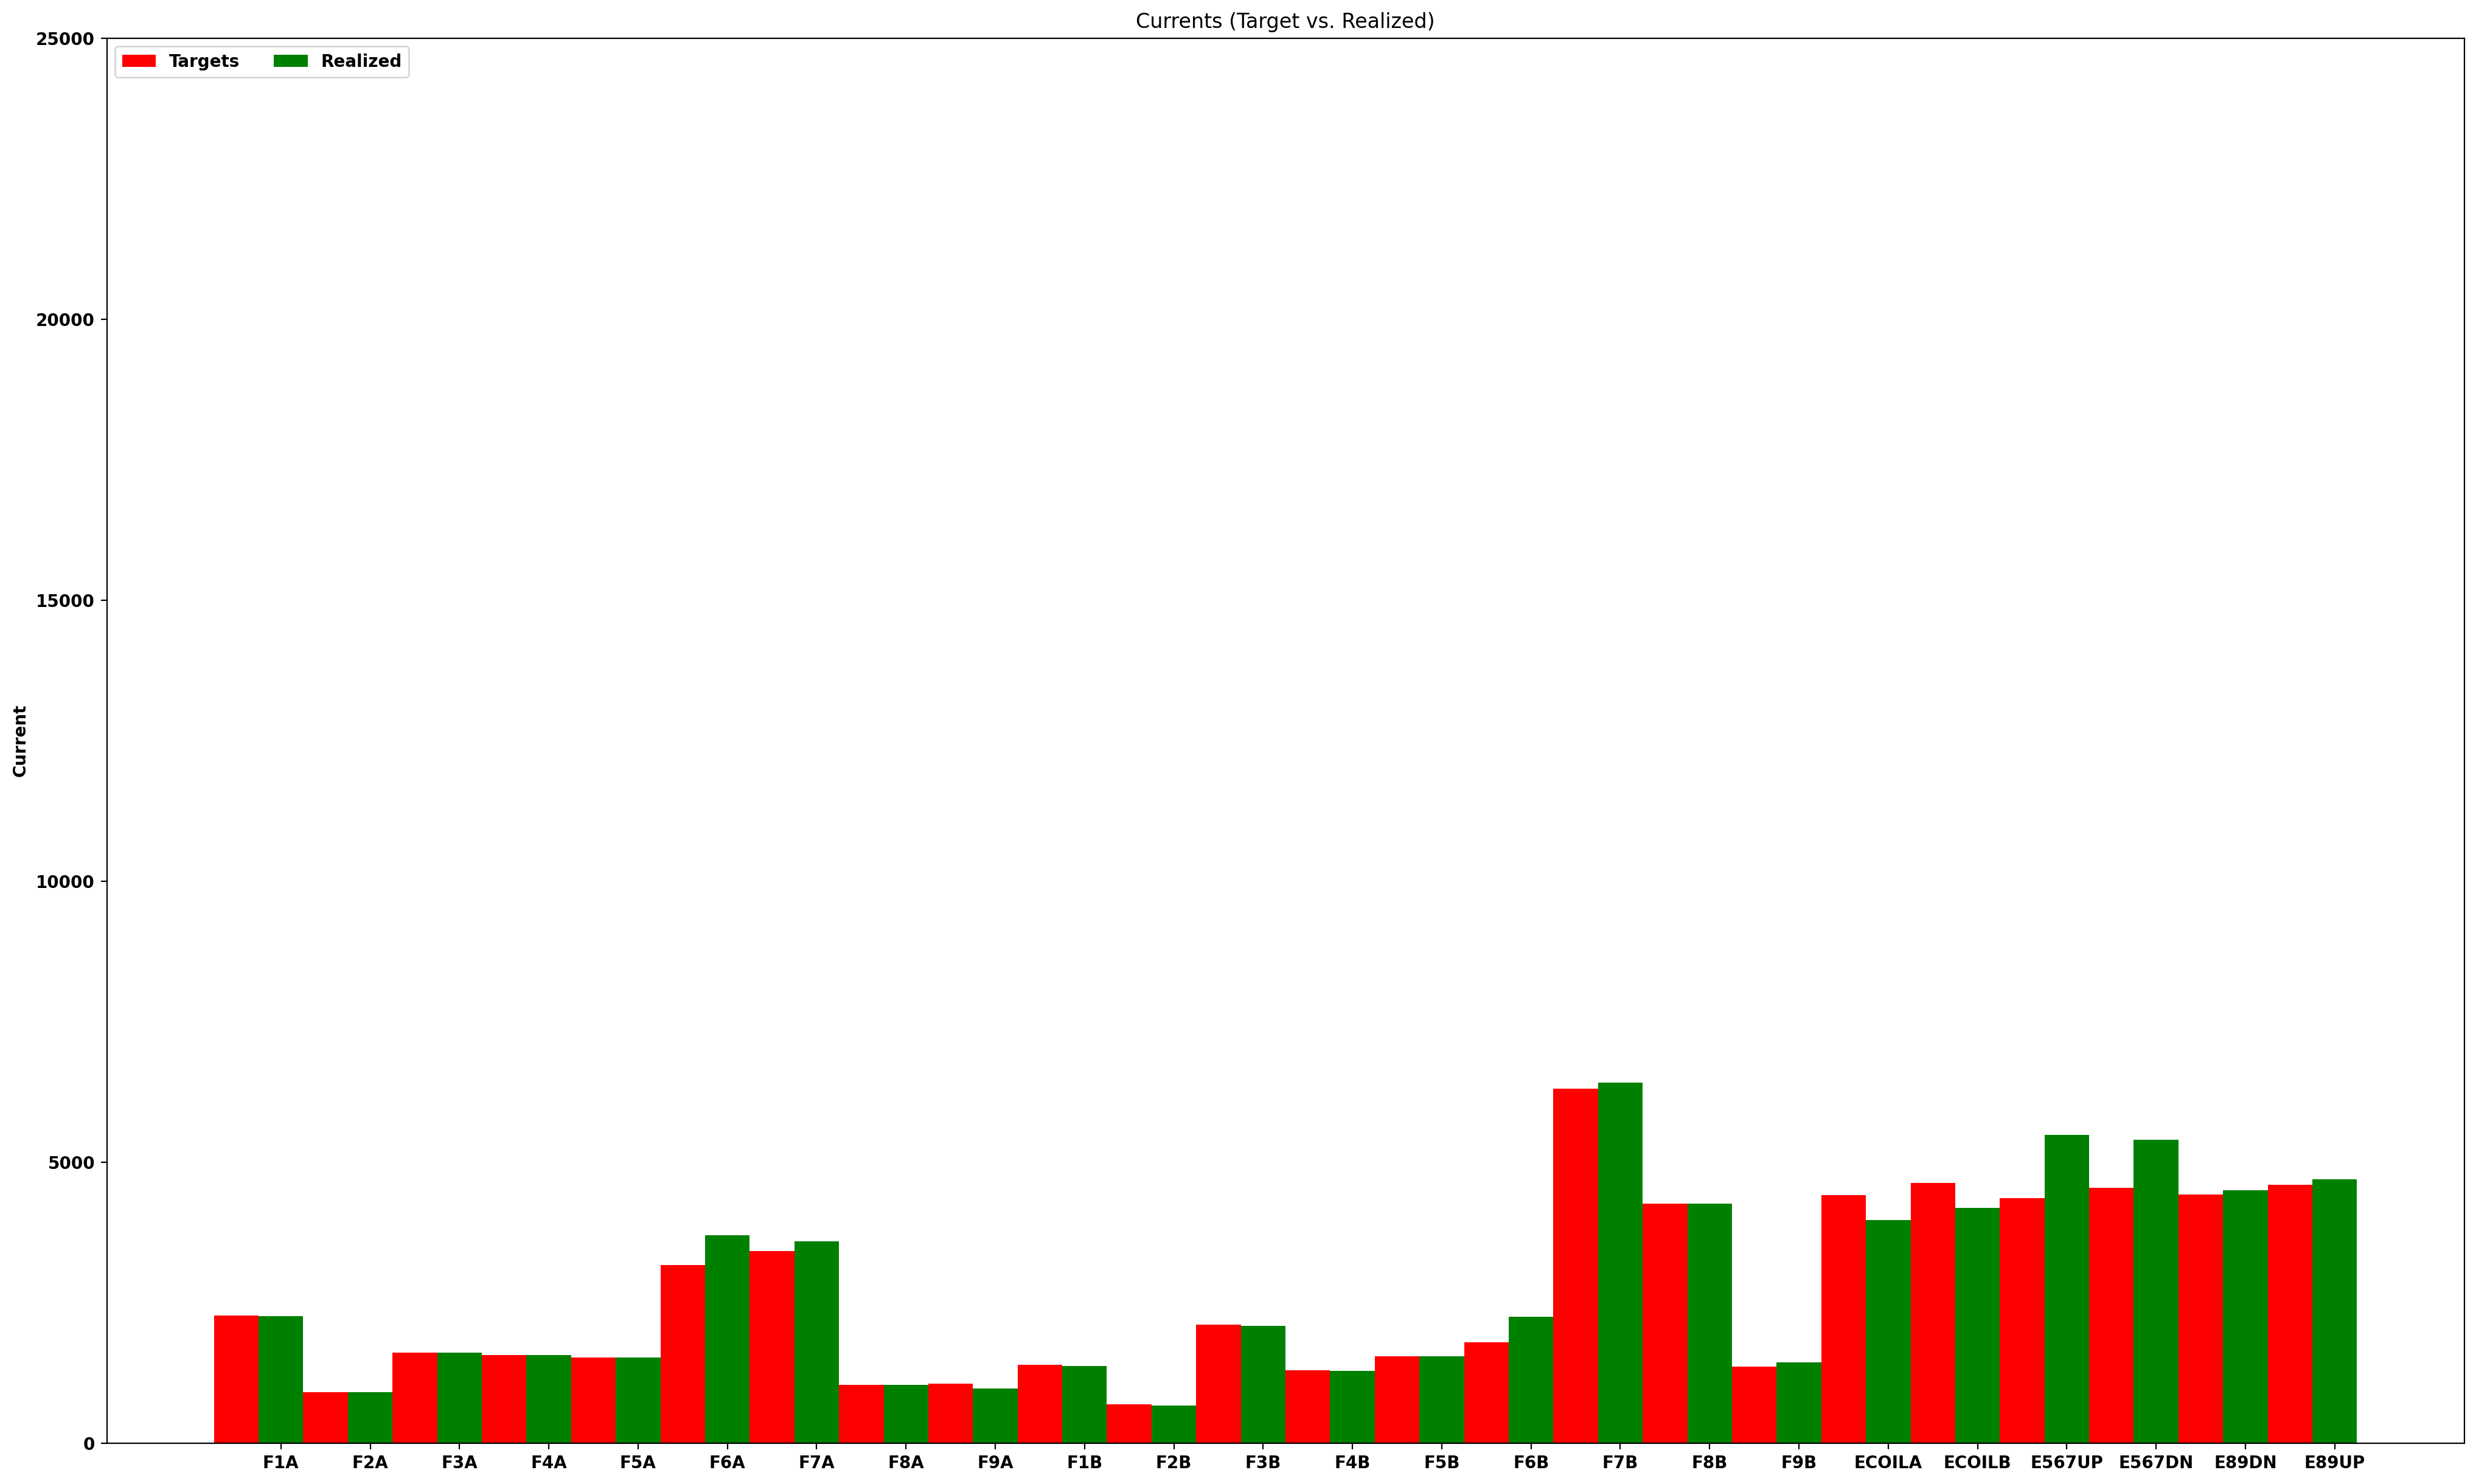

In [24]:
plot_colors = {'Targets': 'red', 'Realized': 'green'}

def plot_currents():
    coil_currents, _ = mygs.get_coil_currents()
    coil_names = [key for key in coil_currents if key in target_currents]
    coil_info = {'Targets': [abs(target_currents[key]) for key in coil_names if key in target_currents],
                 'Realized': [abs(coil_currents[key]) for key in coil_names if key in target_currents]}
    
    x = np.arange(len(coil_names))  # the label locations
    width = 0.5  # the width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots(figsize=(25, 15))
    
    for attribute, measurement in coil_info.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute, color=plot_colors[attribute])
    #     ax.bar_label(rects, padding=3)
        multiplier += 1
    
    ax.set_ylabel('Current')
    ax.set_title('Currents (Target vs. Realized)')
    ax.set_xticks(x + width, coil_names)
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 2.5E4)
    
    plt.show()

plot_currents()

### Plot SE Sensors

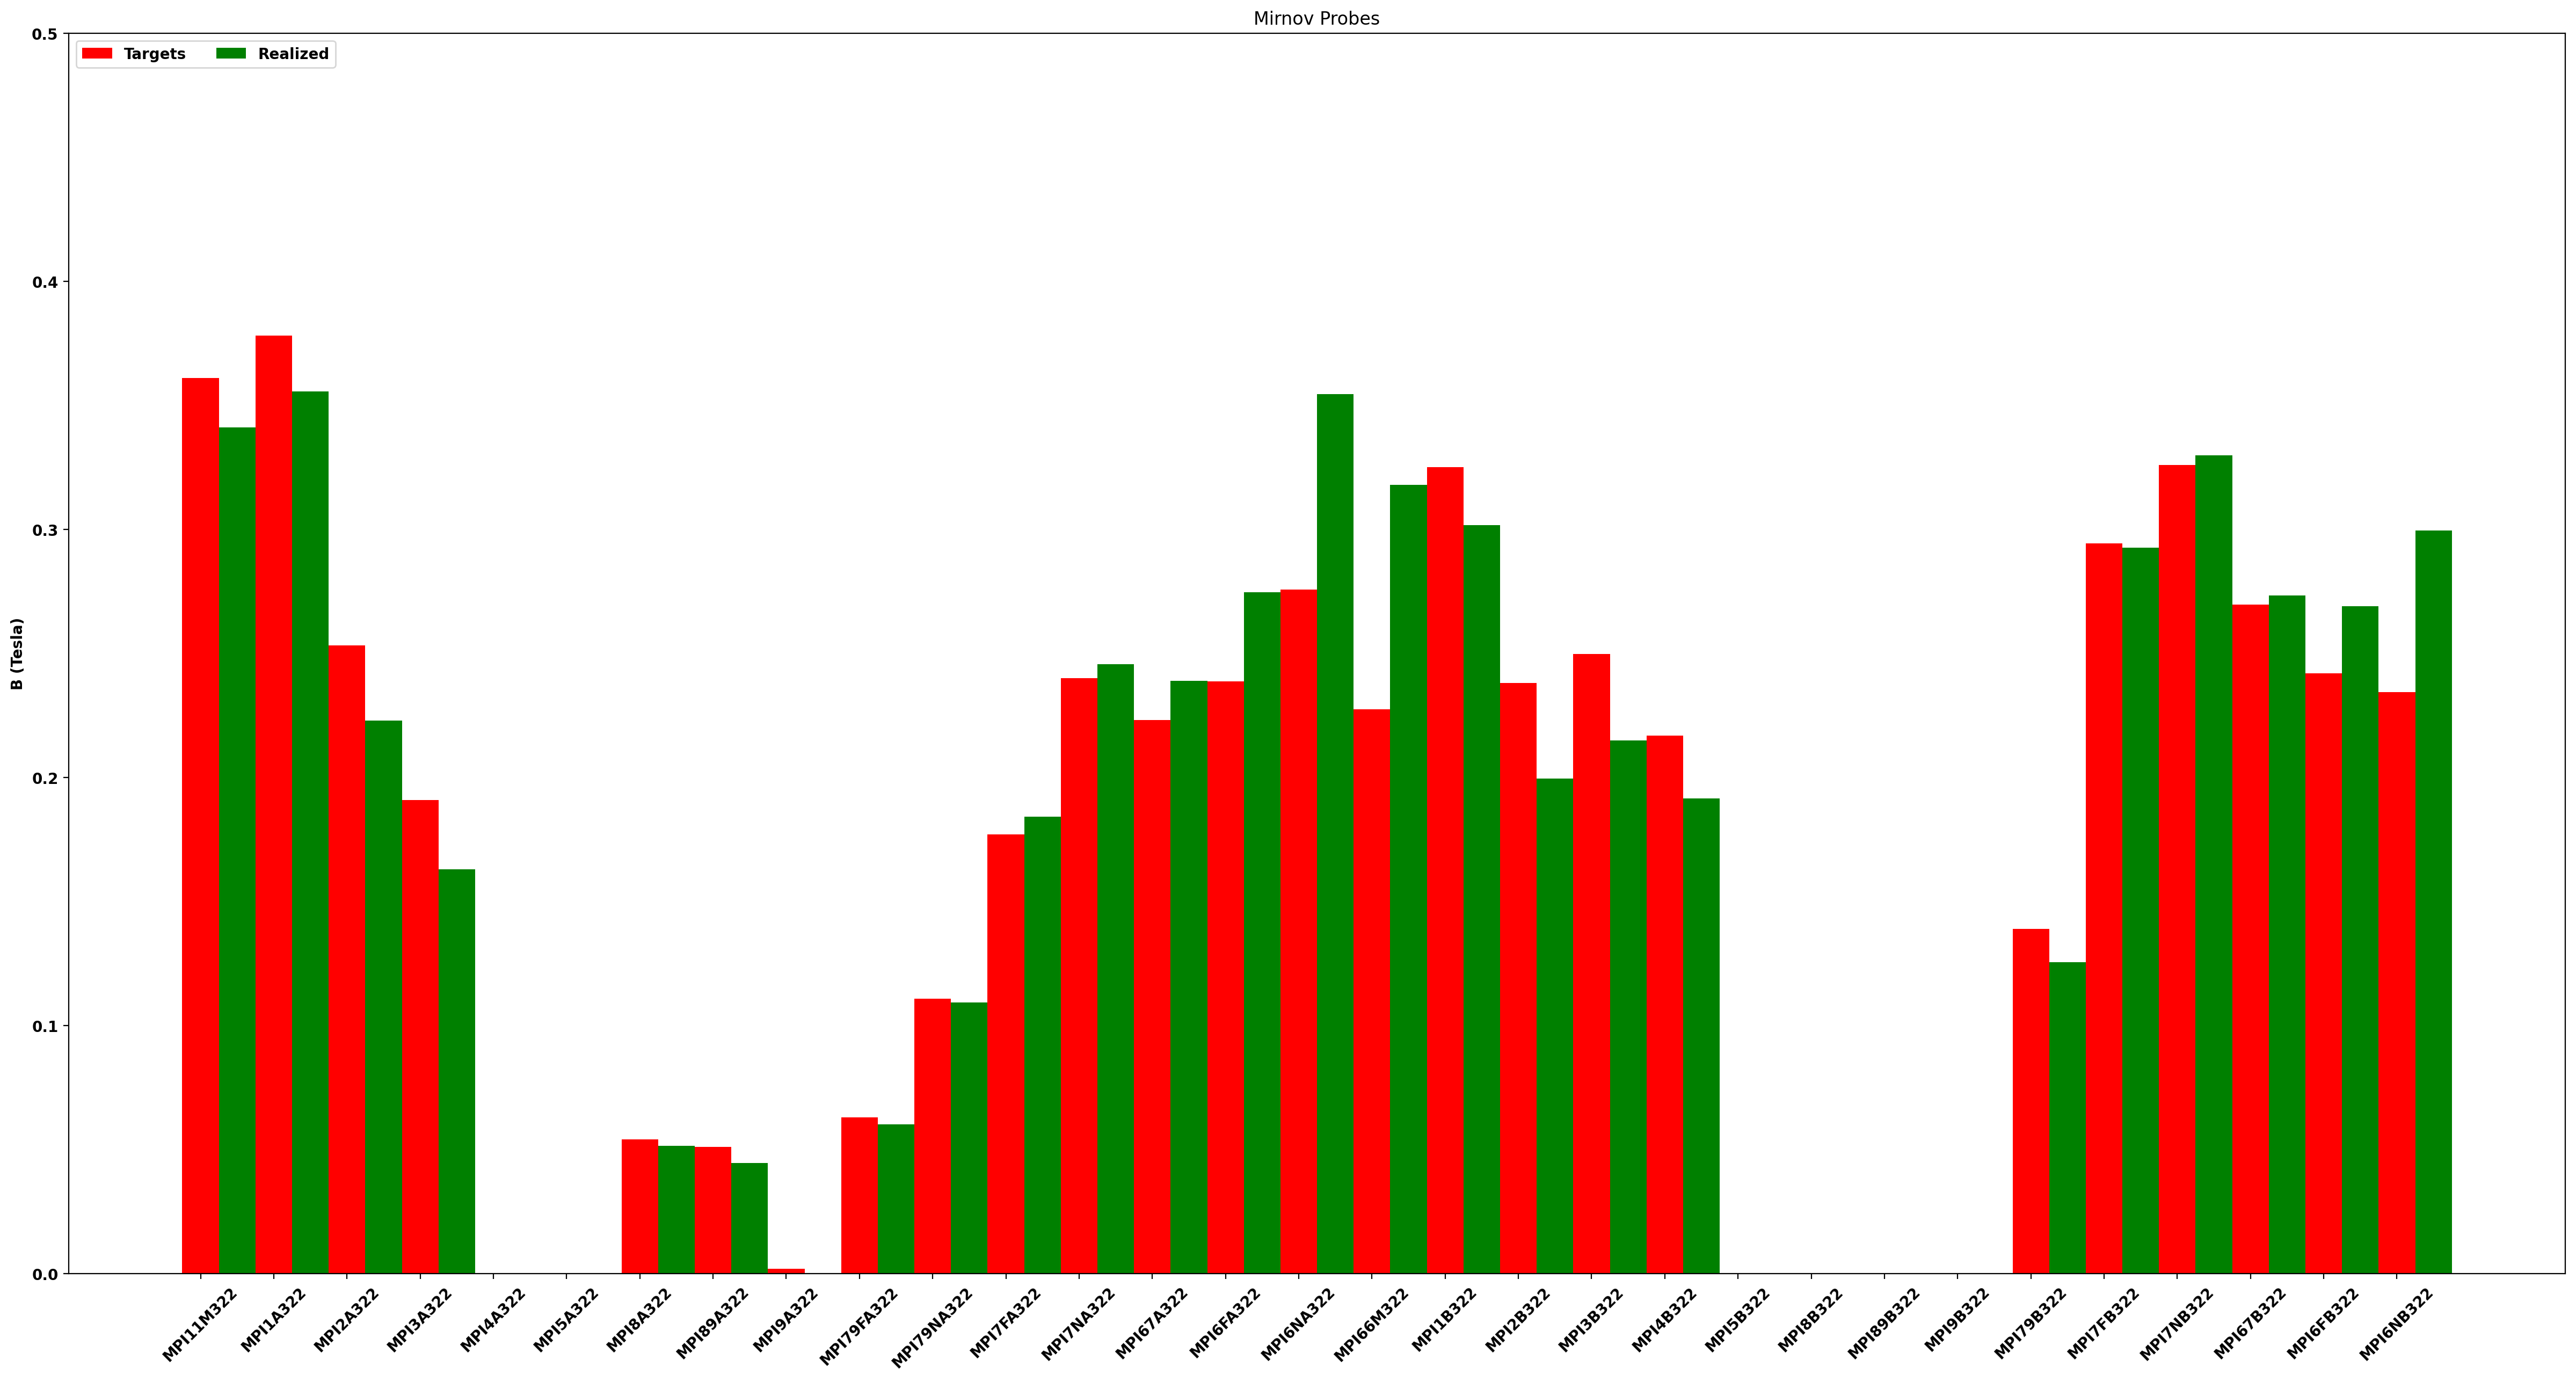

In [25]:
def plot_mirnov():
    mirnov_vals = []
    B_eval = mygs.get_field_eval('B')
    for key in mirnov_names:
        coords = magSensors322[key]
        position, orientation = convert_Mirnov_coordinates(coords, machine_dict['AMP2'][key])
        B_field = B_eval.eval(position)
        mirnov_vals.append(np.dot(B_field, orientation))
    
    mirnov_targets = [probes_dict[key][0] for key in mirnov_names]
    mirnov_info = {'Targets': mirnov_targets,
                 'Realized': mirnov_vals}
    
    x_m = np.arange(len(mirnov_names))  # the label locations
    width = 0.5  # the width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots(1, figsize=(30, 15))
    
    for attribute, measurement in mirnov_info.items():
        offset = width * multiplier
        rects_m = ax.bar(x_m + offset, measurement, width, label=attribute, color=plot_colors[attribute])
        multiplier += 1
    
    ax.set_ylabel('B (Tesla)')
    ax.set_title('Mirnov Probes')
    ax.legend(loc='upper left', ncols=3)
    ax.set_ylim(0, 0.5)
    ax.set_xticks(x_m, labels=mirnov_names, rotation=45)
    
    plt.show()

plot_mirnov()

{'PSF1A': -0.2463725535652459, 'PSF2A': -0.1901906625350929, 'PSF3A': -0.21286141388539007, 'PSF4A': 0.05102587611817232, 'PSF5A': 0.08032549186006954, 'PSF8A': -0.1587449470810644, 'PSF9A': -0.0491354120324087, 'PSF7FA': -1.092808037759317, 'PSF6FA': -1.3692176788776083, 'PSF6NA': -1.2124560581412085, 'PSF6NB': -1.0337968863151465, 'PSF7NB': -2.0925707057541403, 'PSF7FB': -1.6584099624904285, 'PSF9B': 0.31617226535478066, 'PSF8B': 0.8656040102626433, 'PSF5B': 0.3574638800439173, 'PSF4B': -0.12538552276026133, 'PSF3B': -0.3086719419024813, 'PSF2B': -0.17604780747735557, 'PSF1B': -0.18052773076334216, 'PSI11M': -0.144375011208872, 'PSI12A': -0.15491389426347094, 'PSI23A': -0.16741075849997678, 'PSI45A': 0.05021540463769928, 'PSI58A': -0.0010362563503723361, 'PSI9A': -0.09537516526815532, 'PSI7A': -1.0098523458669835, 'PSI6A': -1.0529892194175794, 'PSI6B': -1.0135826777259638, 'PSI7B': -1.5523762629205027, 'PSI9B': -0.1300963067757903, 'PSI89NB': 0.38039231918252225, 'PSI89FB': 0.5772345

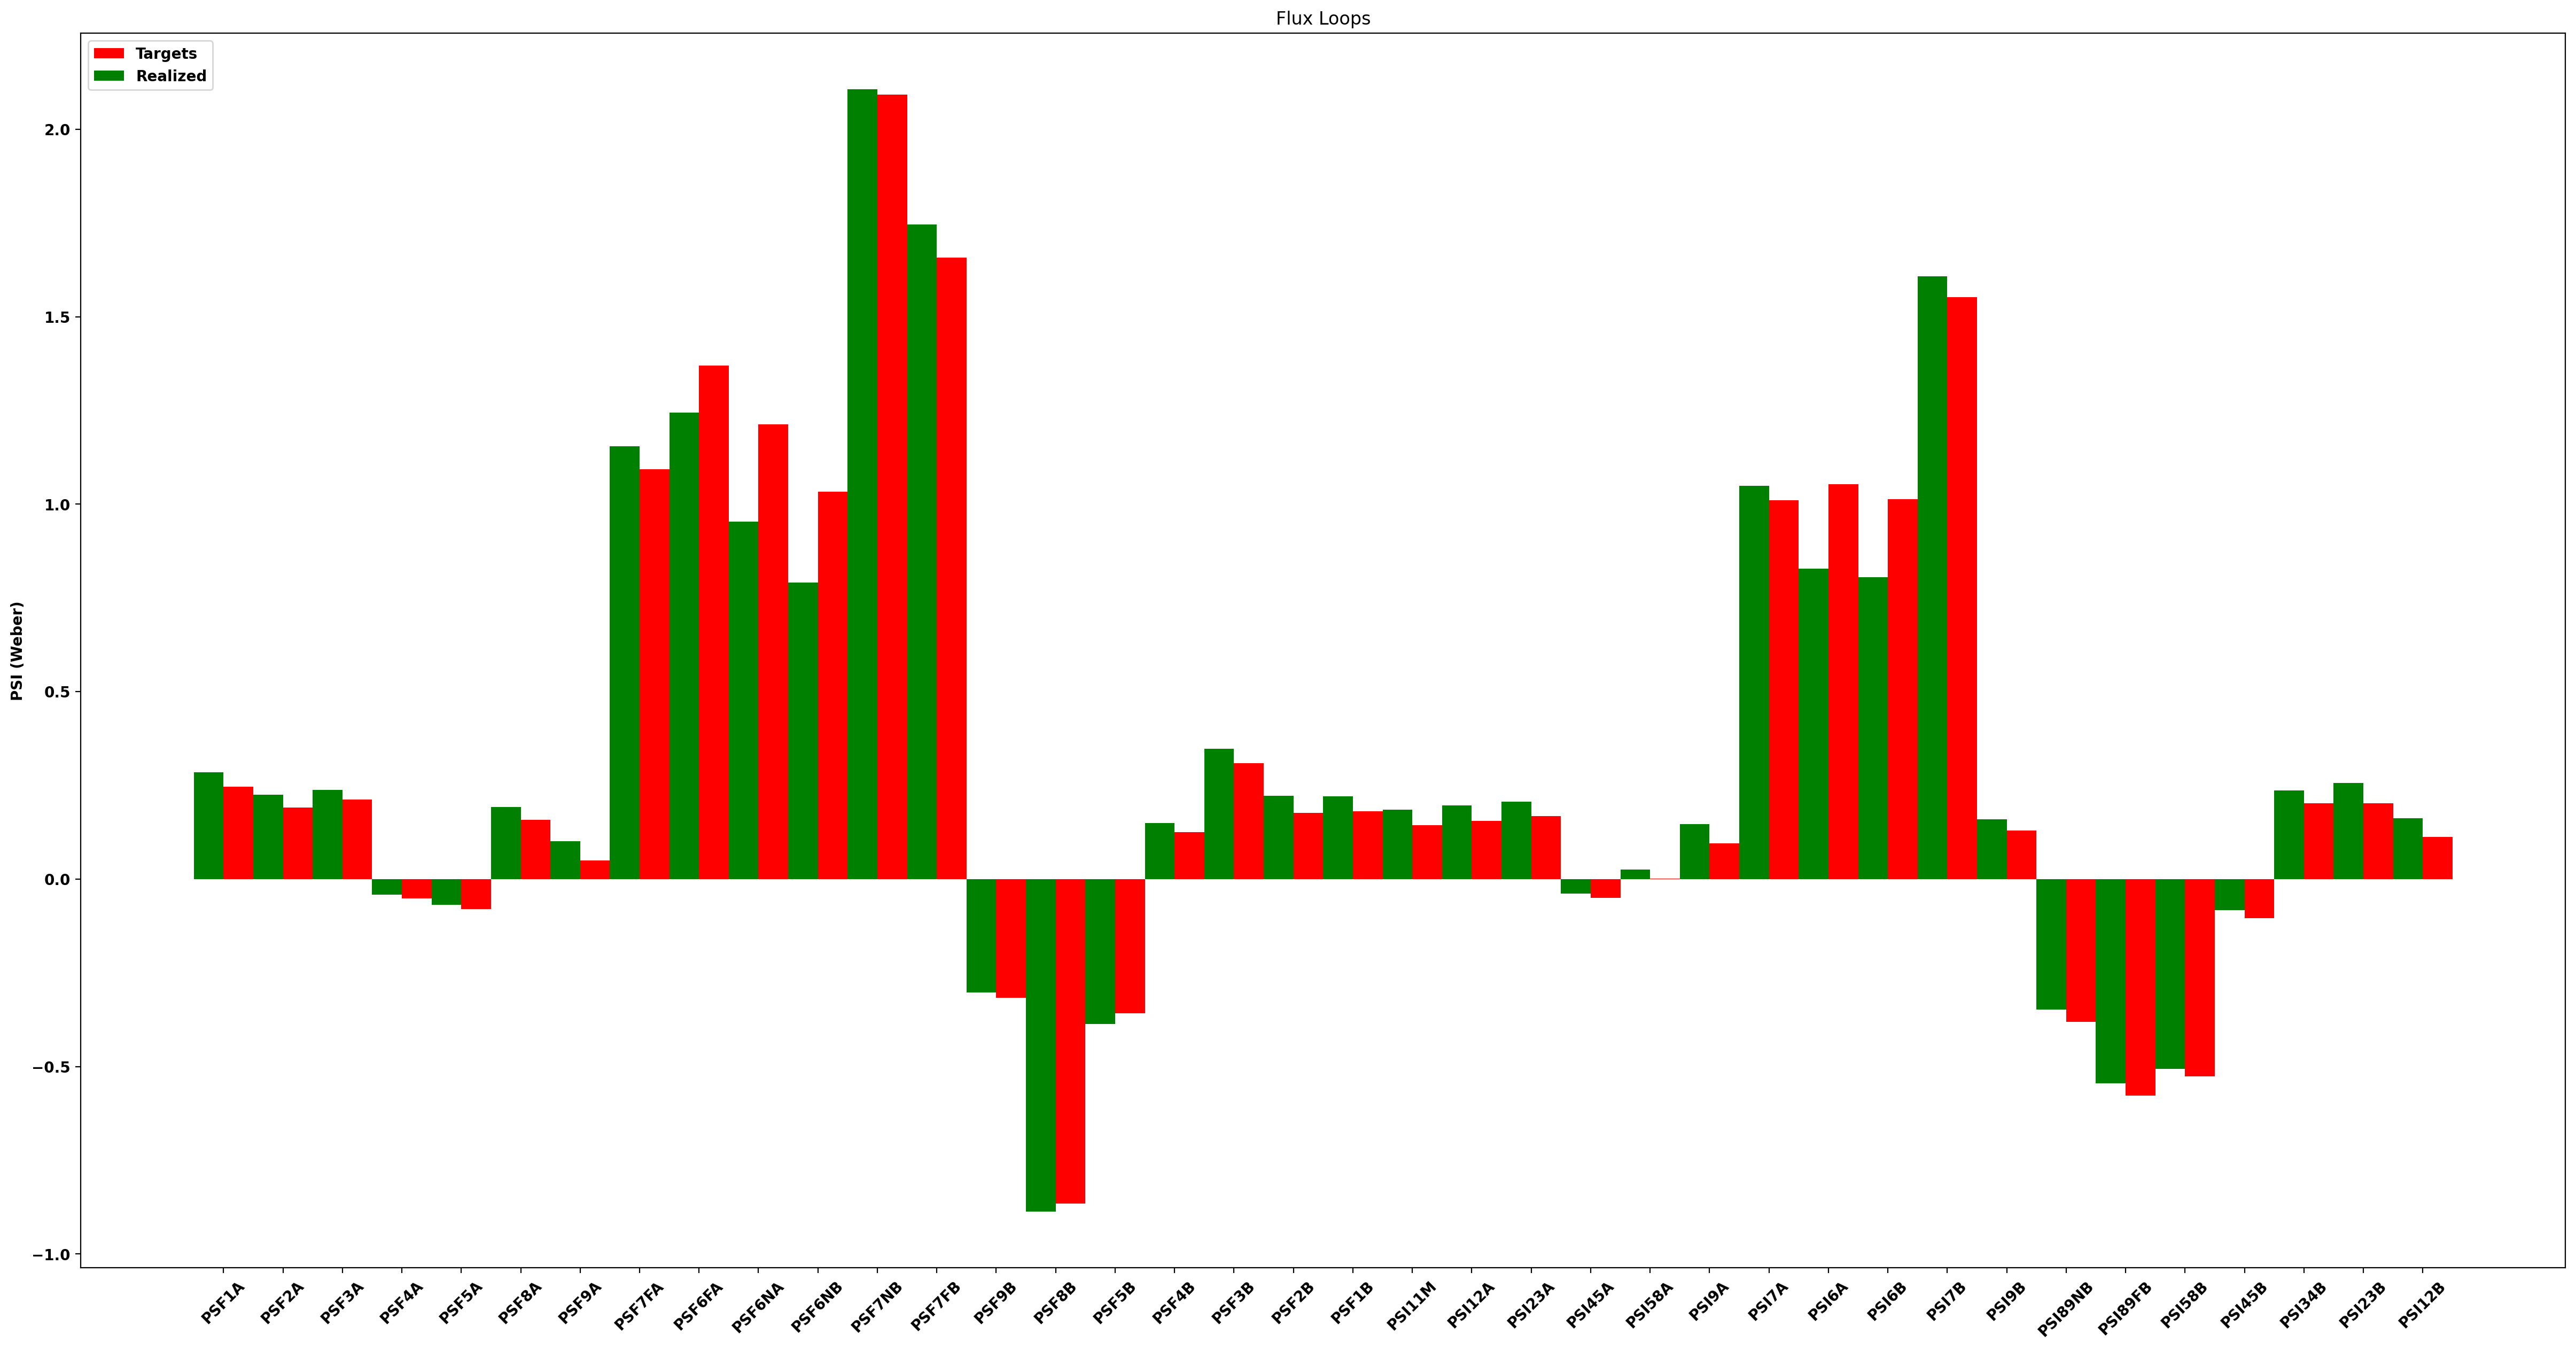

In [26]:
from matplotlib.patches import Patch

def plot_flux():
    flux_vals = []
    flux_dict = {**fluxLoops_onf, **fluxLoops_vv}
    psi_eval = mygs.get_field_eval('PSI')
    for key in flux_names:
        position = flux_dict[key]
        psi_value = psi_eval.eval(position) * 2 * np.pi
        flux_vals.append(psi_value)

    flux_targets = [2 * np.pi * loops_dict[key][0] if key in loops_dict else 0.0 for key in flux_names]
    flux_info = {'Targets': flux_targets,
                 'Realized': flux_vals}
    
    figs, ax = plt.subplots(1, figsize=(30, 15))
    
    x_f = np.arange(len(flux_names))  # the label locations
    width = 0.5  # the width of the bars
    multiplier = 0
    
    flux_targets_data = {flux_names[i]: flux_targets[i] for i in range(len(flux_names))}
    flux_vals_data = {flux_names[i]: flux_vals[i] for i in range(len(flux_names))}
    print(flux_targets_data)
    
    
    for i in range(len(flux_names)):
        ax.bar(flux_names[i], height = -flux_targets[i], width=0.5, color='red', align='edge')
        ax.bar(flux_names[i], height = -flux_vals[i], width=-0.5, color='green', align='edge')
    
    legend_elements = [Patch(facecolor='red', label='Targets'), Patch(facecolor='green', label='Realized')]
    ax.legend(handles=legend_elements,loc='upper left')
    
    ax.set_ylabel('PSI (Weber)')
    ax.set_title('Flux Loops')
    # ax.set_ylim(0, 1.5)
    ax.set_xticks(x_f, labels=flux_names, rotation=45)
    
    plt.show()

plot_flux()

### Perform Reconstruction

In [27]:
# Remove all shape constraints
mygs.set_isoflux(None)
mygs.set_flux(None,None)
mygs.set_saddles(None)

# Set initial position targets from current values
mygs.set_targets(R0=mygs.o_point[0],V0=mygs.o_point[1])

# Set Recon Plasma Current
myrecon.set_Ip(Ip_target, err=0.1*Ip_target)

# Set reconstruction settings
myrecon.settings.fitPnorm = False
myrecon.settings.fitR0 = True
myrecon.settings.fitV0 = True
myrecon.settings.fitCoils = True
myrecon.settings.pm = False

# Perform reconstructions
err_flag = myrecon.reconstruct()


*** Loading fit constraints ***

Starting Fit:
  # of free parameters   =   27
  # of constraints       =   94

Function evaluation    1
  Alam              = -8.349E+00
  P_scale           =  5.396E-07
  R0_target         =  1.839E+00
  V0_target         =  3.070E-02
  Coil currents [%]  = -0.000E+00 -0.000E+00 -0.000E+00  0.000E+00  0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00  0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00  0.000E+00 -0.000E+00 -0.000E+00  0.000E+00  0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00
  Maximum Rel Error =  2.308E+01
  Maximum Abs Error =  1.576E+01
  Total Weighted Error   =  2.315E+02
  RMS Weighted Error     =  2.387E+01

Function evaluation    2
  Alam              = -8.349E+00
  P_scale           =  5.396E-07
  R0_target         =  1.839E+00
  V0_target         =  3.070E-02
  Coil currents [%]  = -0.000E+00 -0.000E+00 -0.000E+00  0.000E+00  0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00  0.000E+00 -0.000E+00 -0.000E+00

### Print equilibrium information and coil currents
As above we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.print_info "print_info()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_coil_currents "get_coil_currents()" to display information on the final equilibrium.

In [28]:
mygs.print_info()

print()
print("Coil Currents [kA]:")
coil_currents, _ = mygs.get_coil_currents()
for key, current in coil_currents.items():
    if key not in target_currents:
        continue
    measured_currt = target_currents[key]
    pct_diff = 100.0 * (current-measured_currt)/measured_currt
    print('  {0:10} {1:11.3F} {2:11.3F} {3:10.2F}%'.format(key+":", current/1.E3, measured_currt/1.E3, pct_diff))

Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    9.8386E+05
  Current Centroid [m]    =    1.773  0.028
  Magnetic Axis [m]       =    1.788  0.027
  Elongation              =    1.447 (U:  1.386, L:  1.509)
  Triangularity           =    0.318 (U:  0.263, L:  0.373)
  Plasma Volume [m^3]     =   18.300
  q_0, q_95               =   -0.515 -4.367
  Peak Pressure [Pa]      =    9.5271E+04
  Stored Energy [J]       =    5.0519E+05
  <Beta_pol> [%]          =   72.7167
  Diamagnetic flux [Wb]   =   -1.1091E-02
  Toroidal flux [Wb]      =   -3.8514E+00
  l_i                     =    1.8532

Coil Currents [kA]:
  F1A:            -2.255      -2.263      -0.33%
  F2A:            -0.896      -0.907      -1.17%
  F3A:            -1.606      -1.610      -0.24%
  F4A:             1.499       1.562      -4.06%
  F5A:             1.534       1.518       1.00%
  F6A:            -3.694      -3.162      16.85%
  F7A:            -3.390      -3.418      -0.83%

## Plot final reconstructed equilibrium

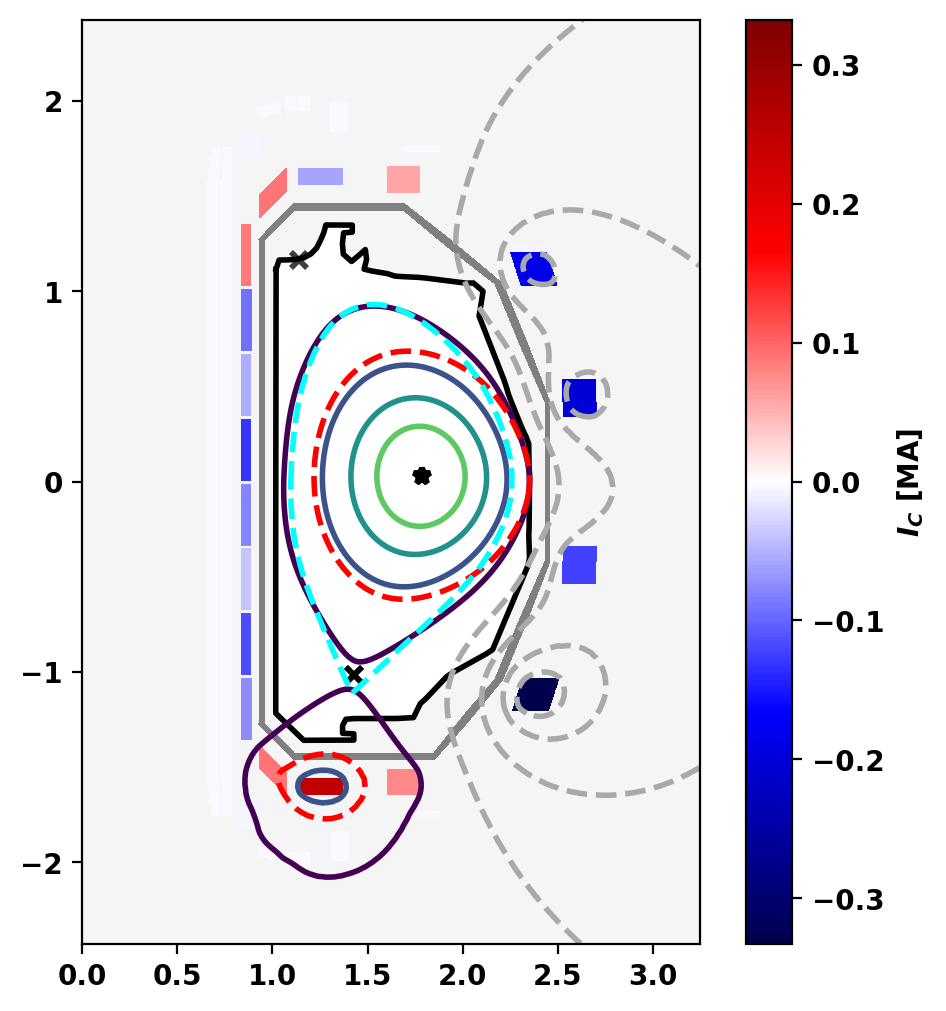

In [29]:
# Plot Psi
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_psi(fig,ax,psi_eq,plasma_levels=[1.0,],plasma_color='red',vacuum_nlevels=0,plasma_linestyles='dashed')

LCFS_eqdsk = eqdsk['rzout']
ax.plot(LCFS_eqdsk[:,0], LCFS_eqdsk[:,1], color='cyan', linestyle='--')

plt.show()

## Plot Currents

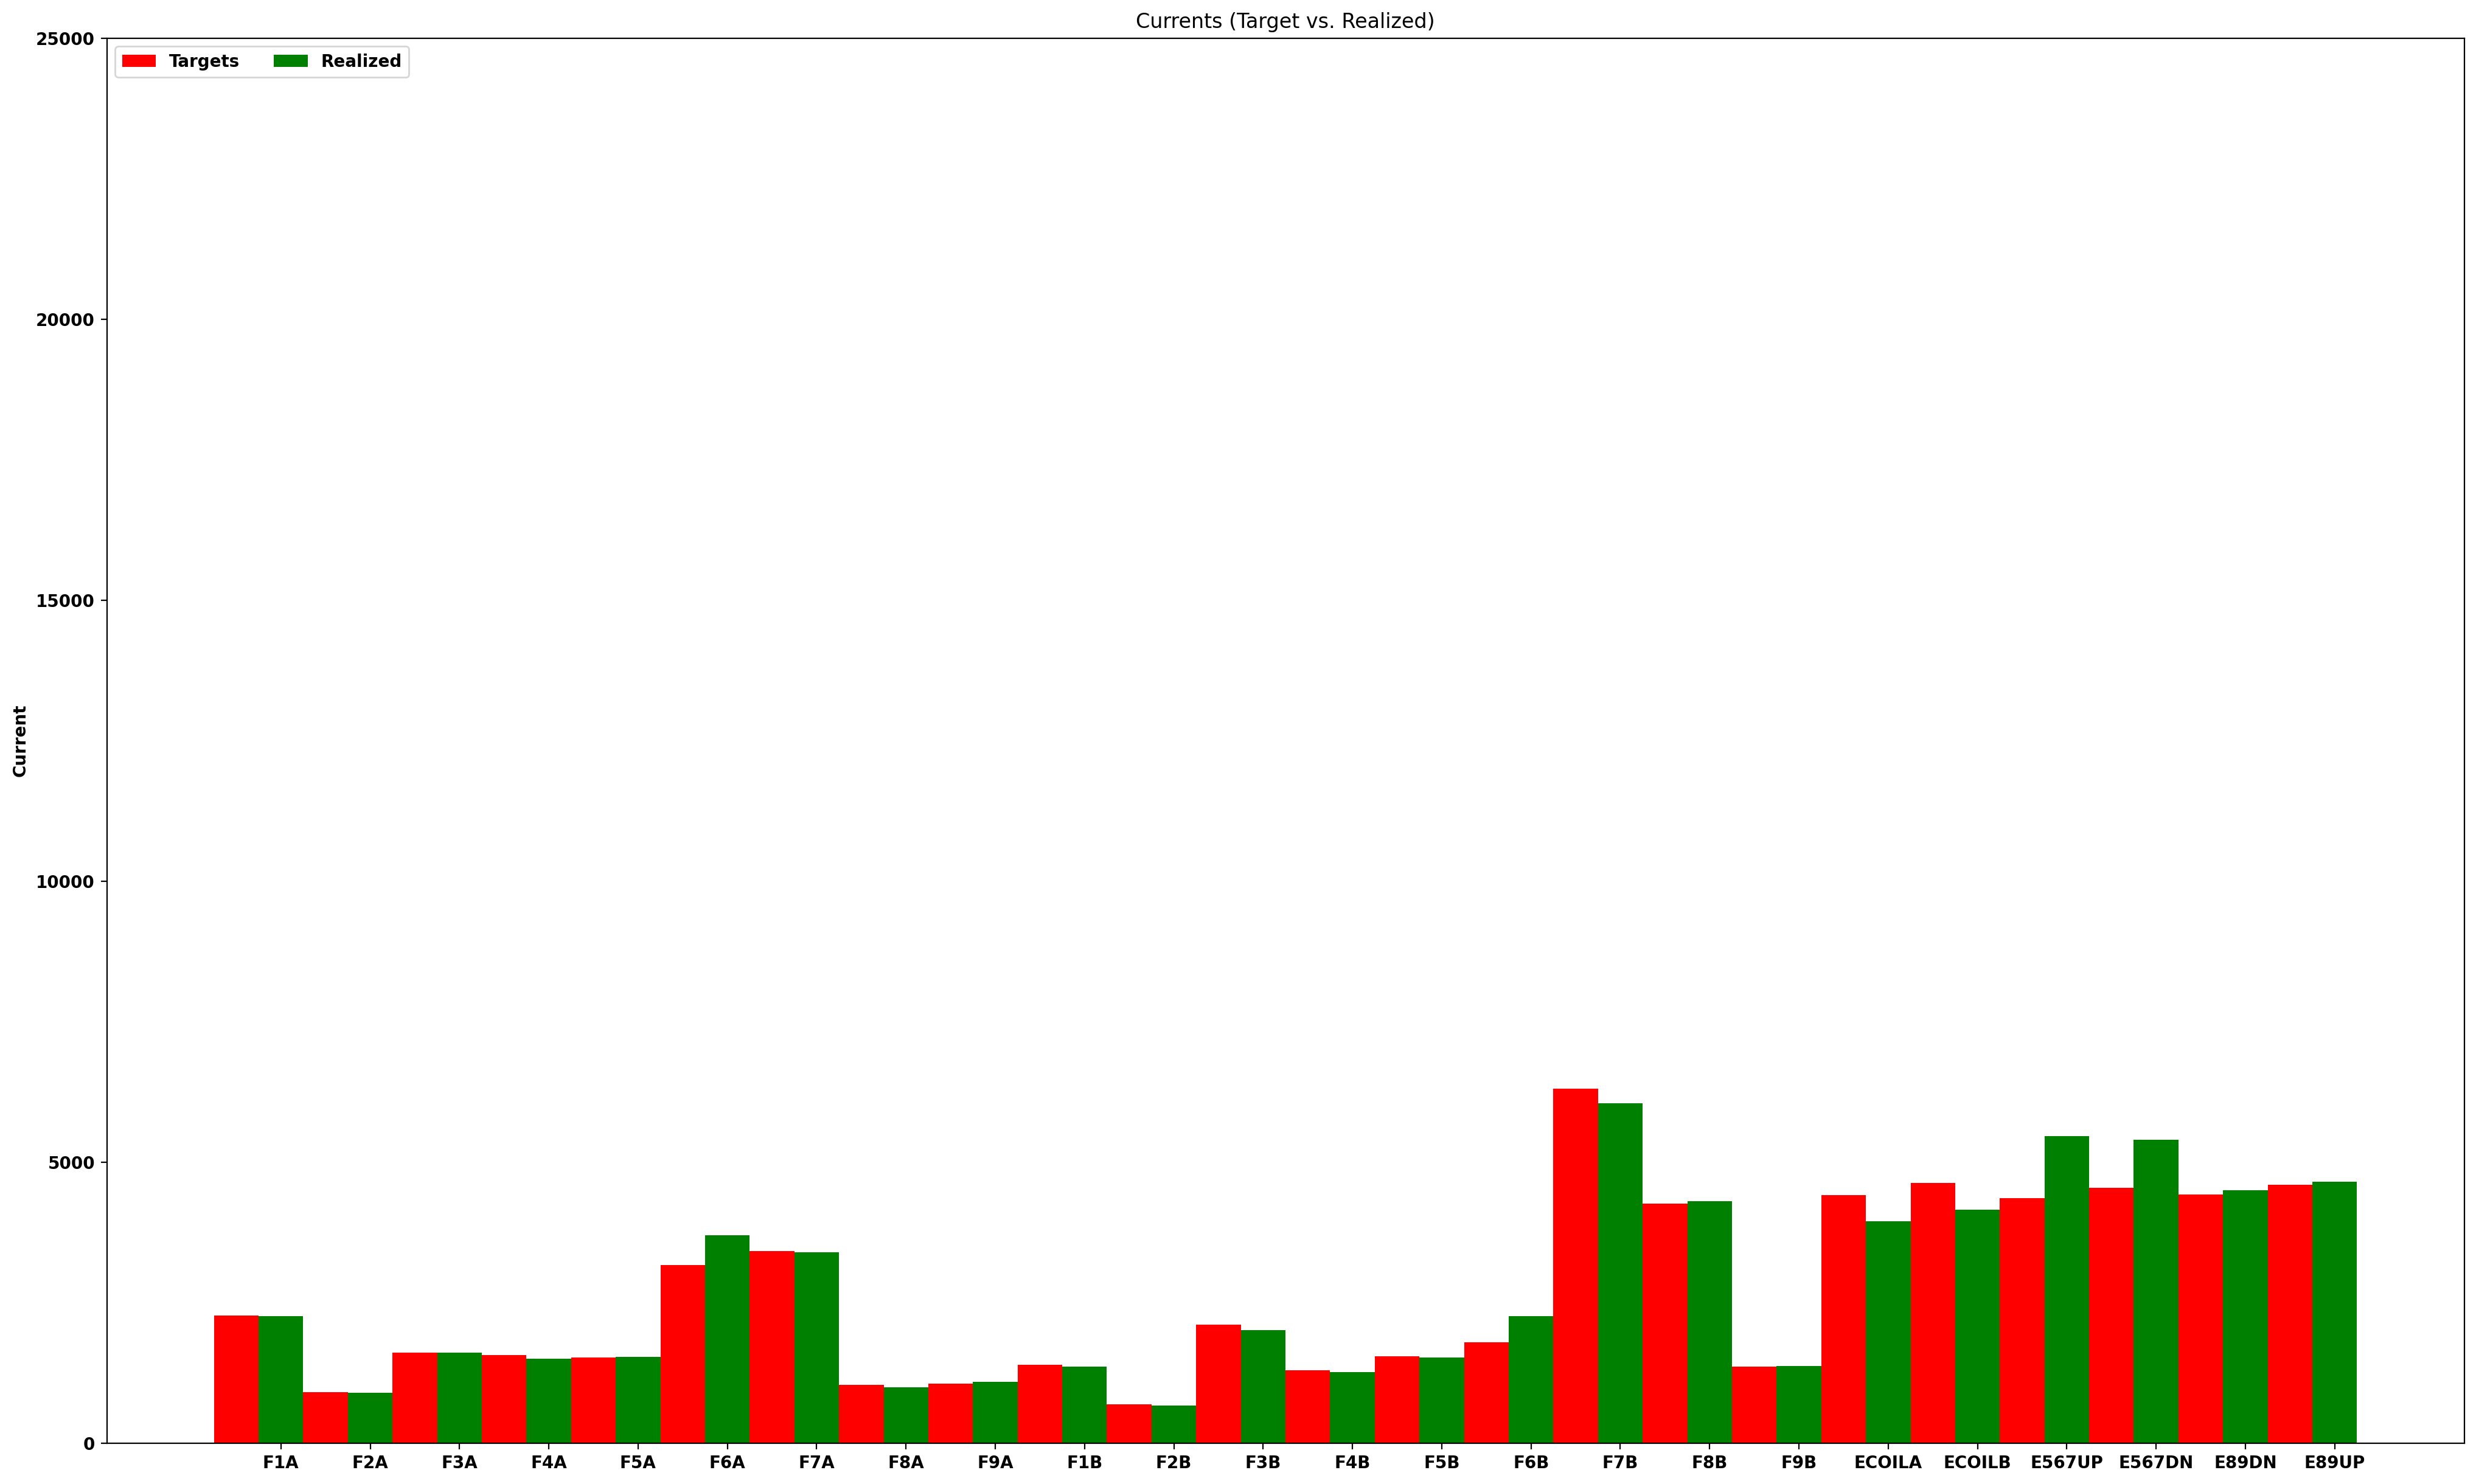

In [30]:
plot_currents()

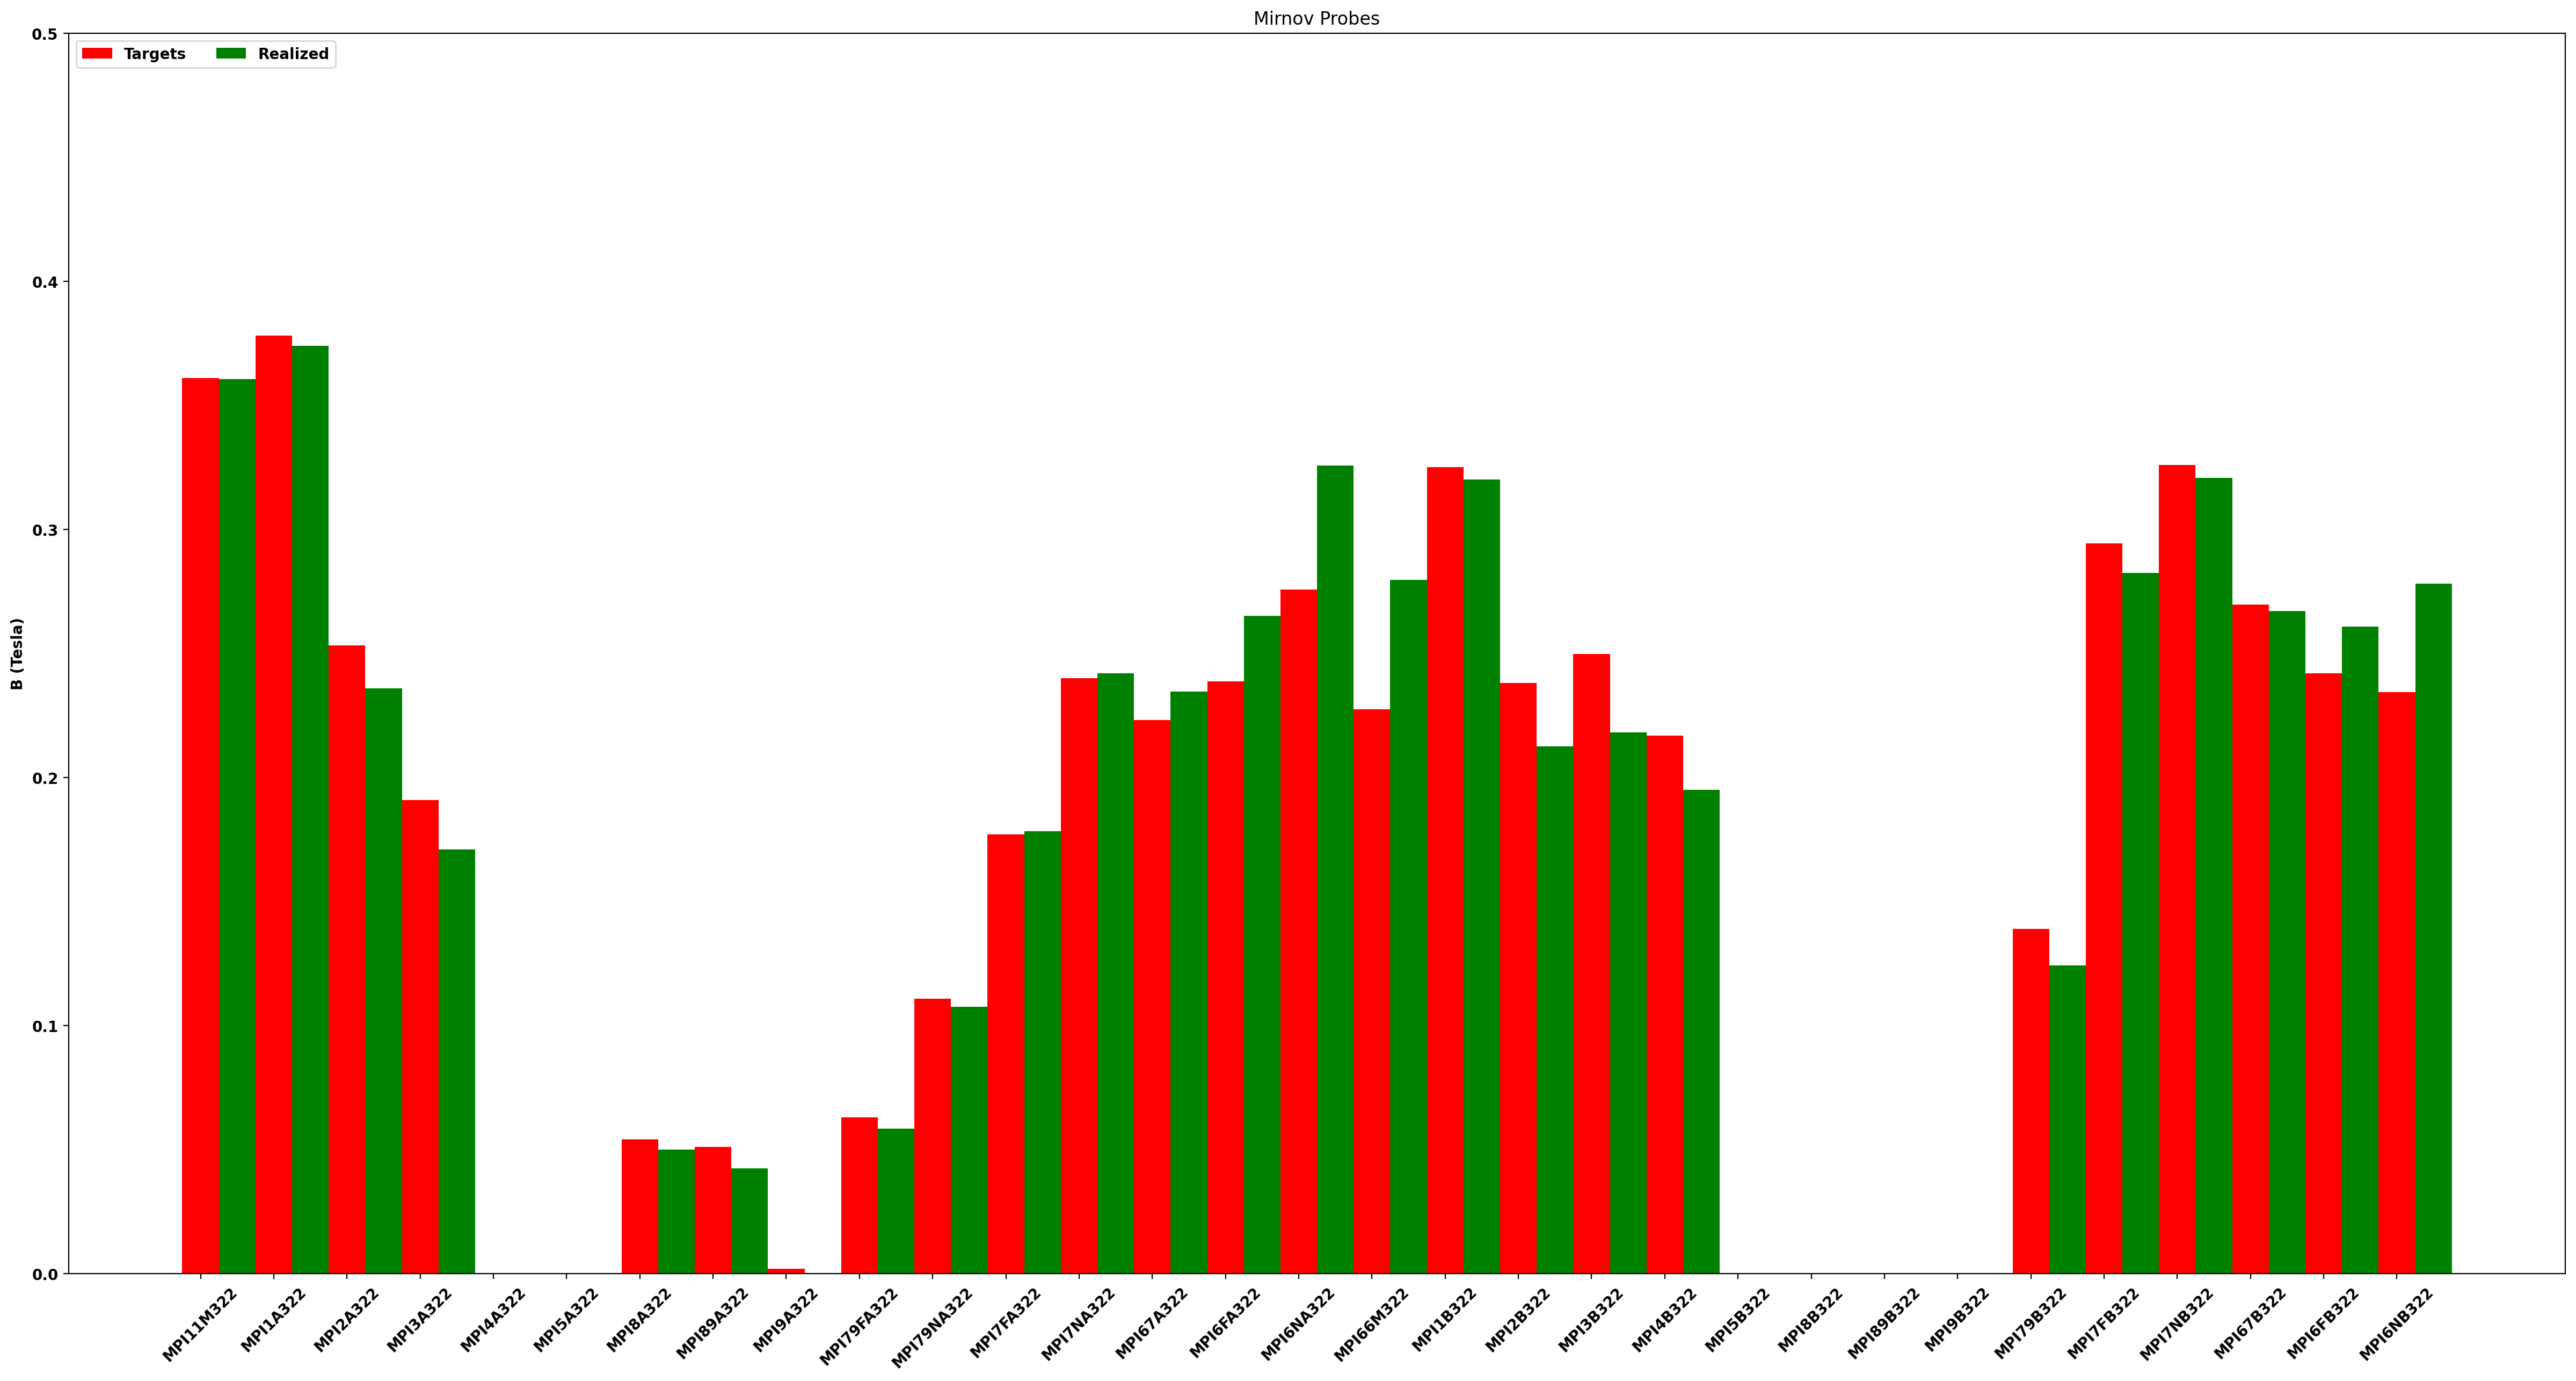

In [31]:
plot_mirnov()

{'PSF1A': -0.2463725535652459, 'PSF2A': -0.1901906625350929, 'PSF3A': -0.21286141388539007, 'PSF4A': 0.05102587611817232, 'PSF5A': 0.08032549186006954, 'PSF8A': -0.1587449470810644, 'PSF9A': -0.0491354120324087, 'PSF7FA': -1.092808037759317, 'PSF6FA': -1.3692176788776083, 'PSF6NA': -1.2124560581412085, 'PSF6NB': -1.0337968863151465, 'PSF7NB': -2.0925707057541403, 'PSF7FB': -1.6584099624904285, 'PSF9B': 0.31617226535478066, 'PSF8B': 0.8656040102626433, 'PSF5B': 0.3574638800439173, 'PSF4B': -0.12538552276026133, 'PSF3B': -0.3086719419024813, 'PSF2B': -0.17604780747735557, 'PSF1B': -0.18052773076334216, 'PSI11M': -0.144375011208872, 'PSI12A': -0.15491389426347094, 'PSI23A': -0.16741075849997678, 'PSI45A': 0.05021540463769928, 'PSI58A': -0.0010362563503723361, 'PSI9A': -0.09537516526815532, 'PSI7A': -1.0098523458669835, 'PSI6A': -1.0529892194175794, 'PSI6B': -1.0135826777259638, 'PSI7B': -1.5523762629205027, 'PSI9B': -0.1300963067757903, 'PSI89NB': 0.38039231918252225, 'PSI89FB': 0.5772345

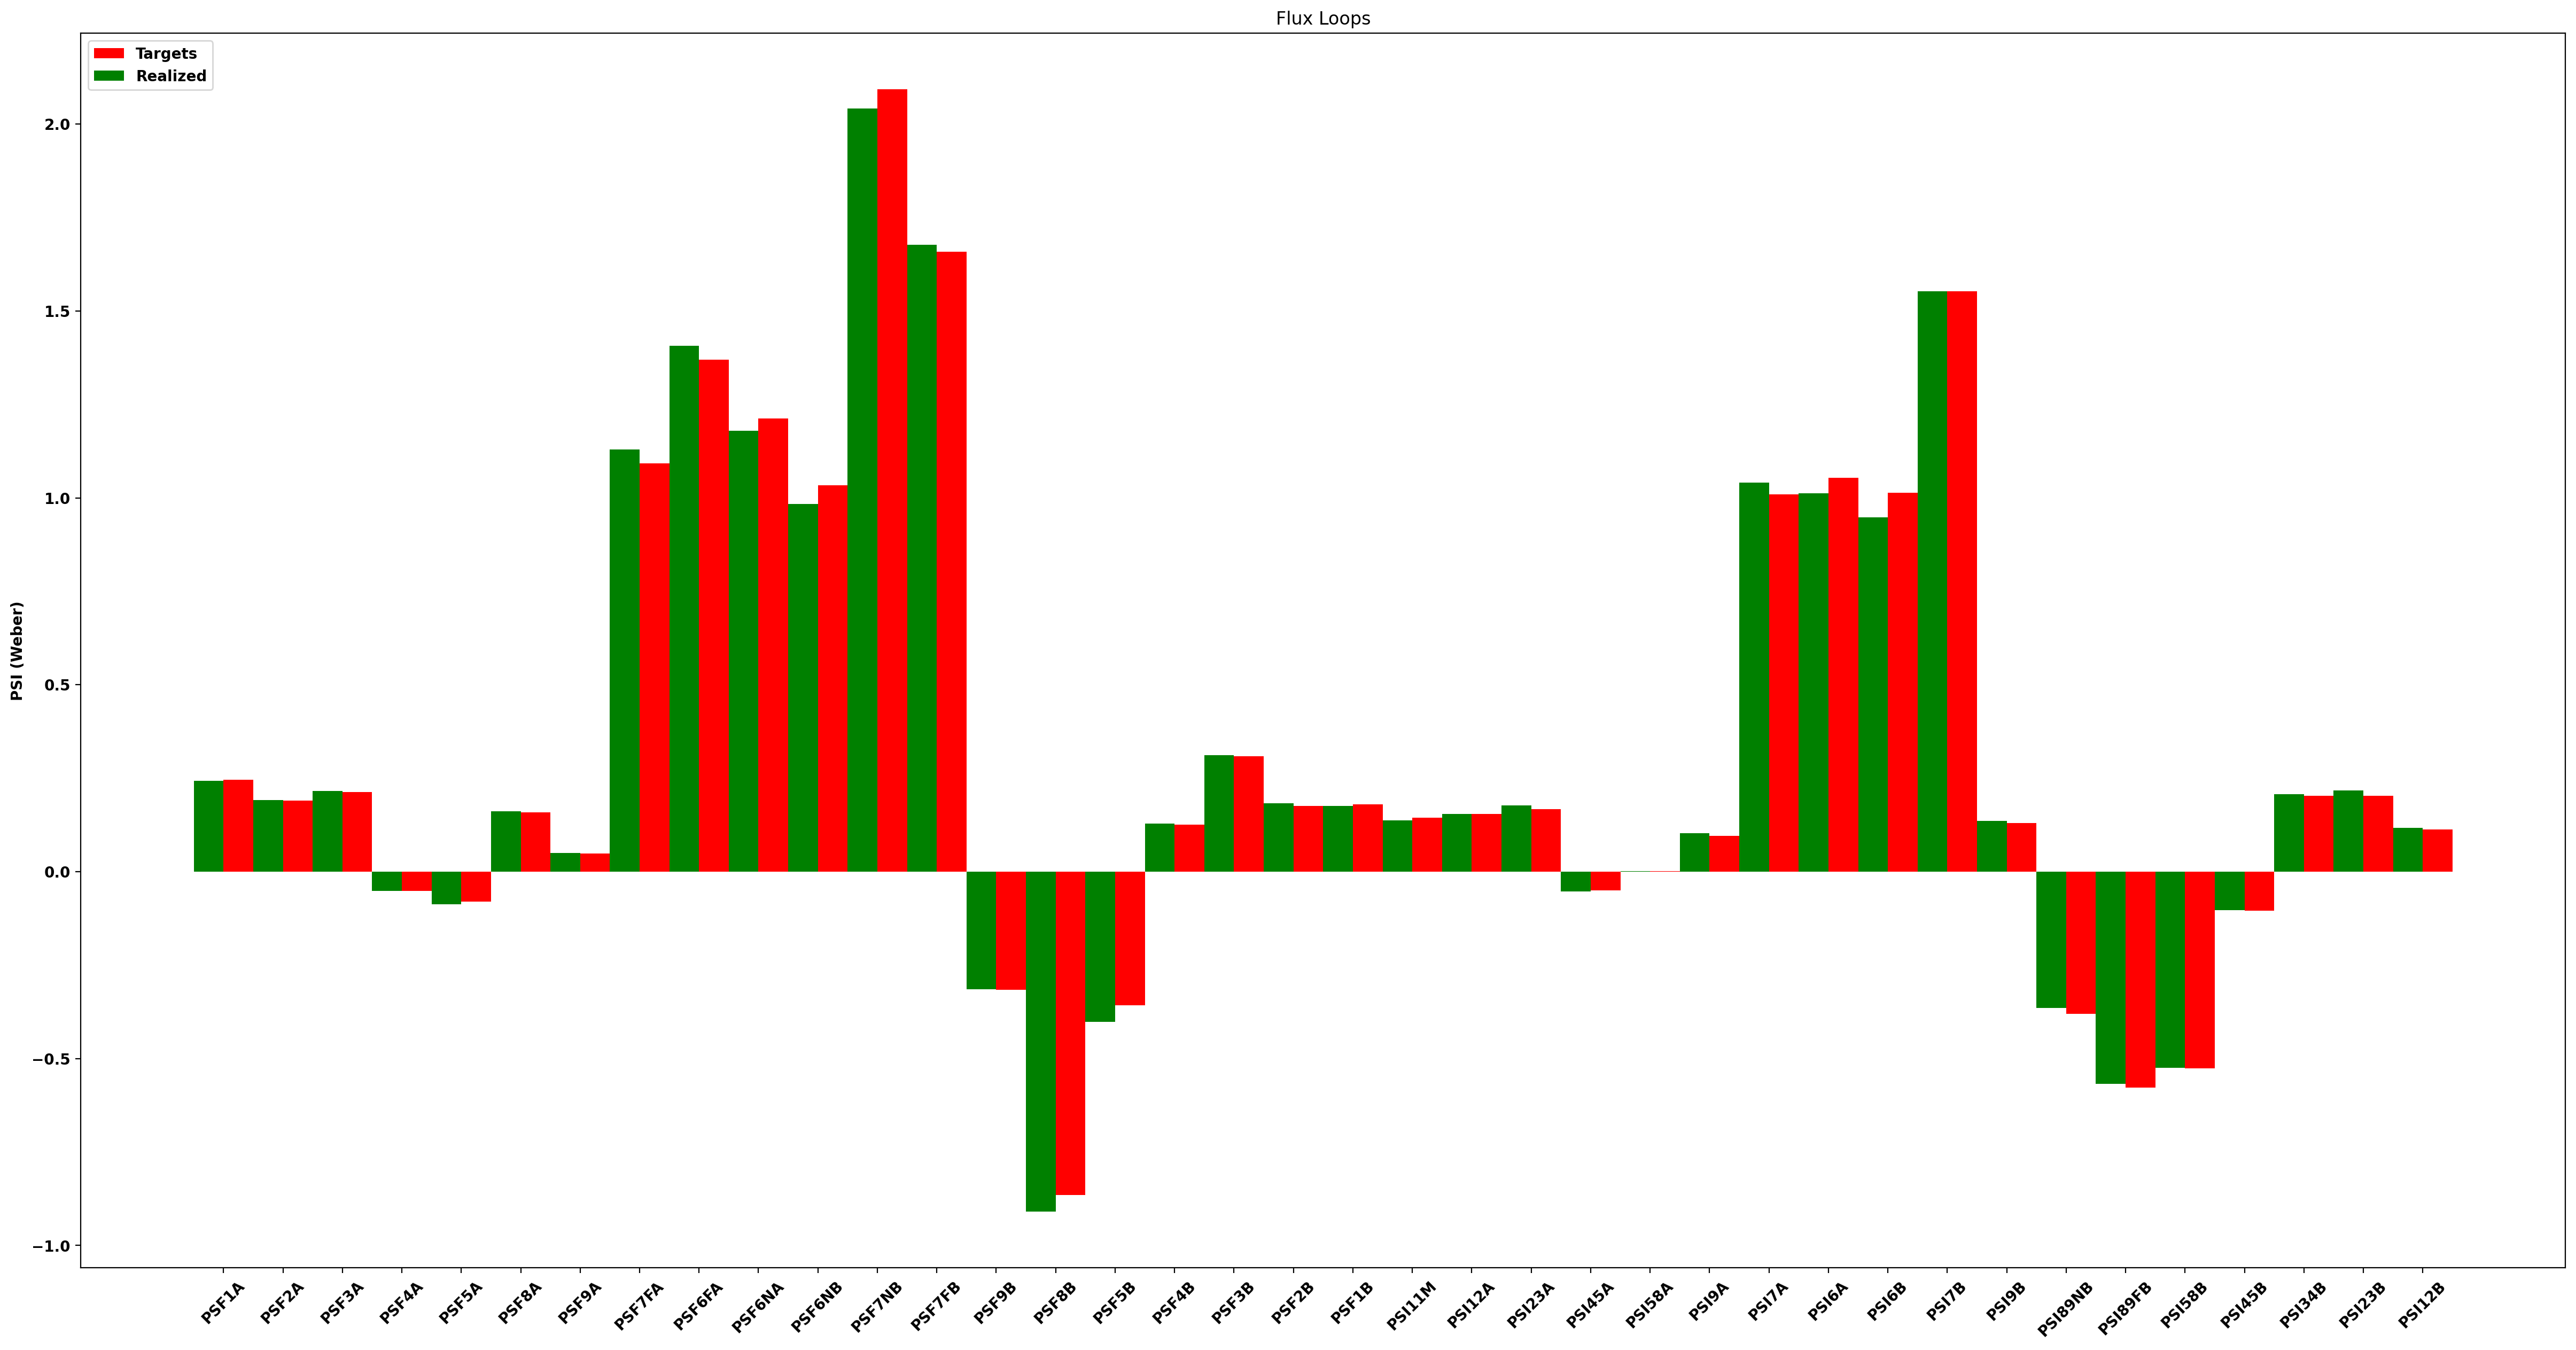

In [32]:
plot_flux()

## Get Strike Points

In [33]:
strike_pts = mygs.get_strike_points()
print(strike_pts)

[array([ 1.07467975, -1.27221152]), array([ 1.56246952, -1.24478983])]


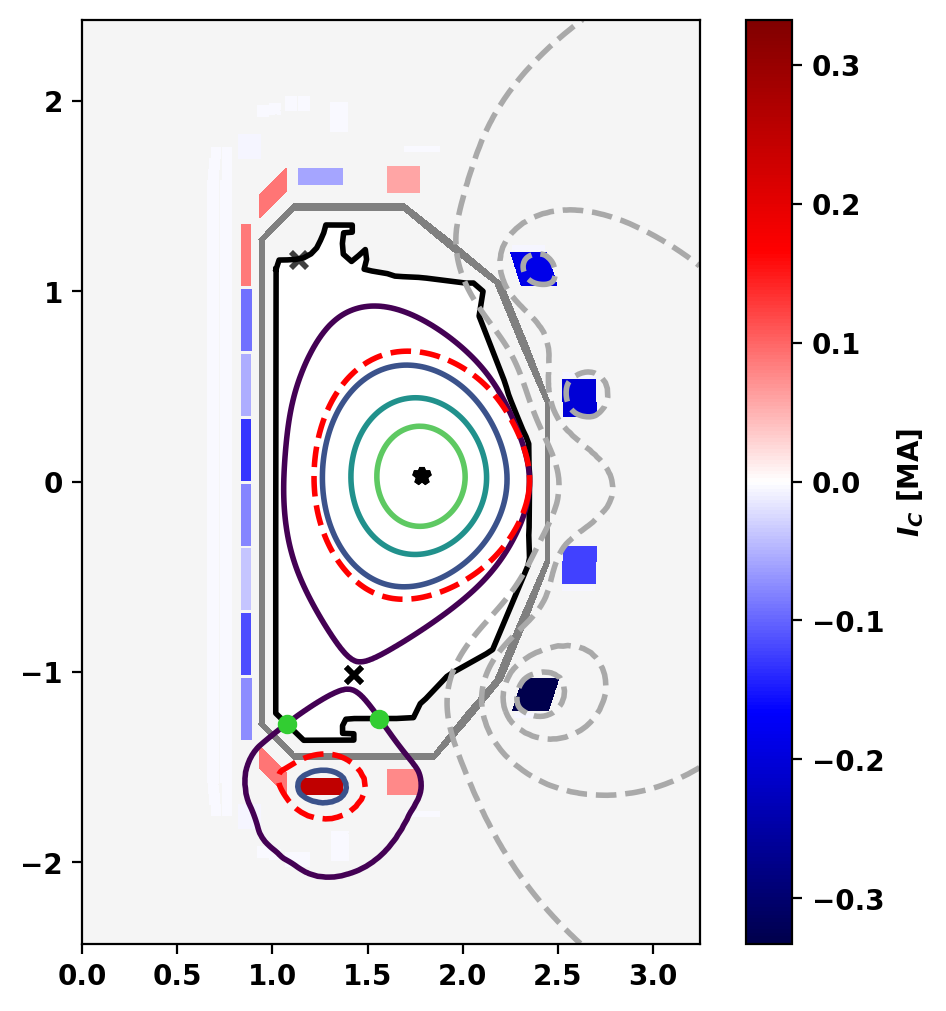

In [34]:
# Plot Psi
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_psi(fig,ax,psi_eq,plasma_levels=[1.0,],plasma_color='red',vacuum_nlevels=0,plasma_linestyles='dashed')

strike_pts_r = [sp[0] for sp in strike_pts]
strike_pts_z = [sp[1] for sp in strike_pts]
ax.scatter(strike_pts_r, strike_pts_z, color='limegreen', zorder=10)

plt.show()